# eThekwini Building Detection Model Training and Inference Notebook

## 1. Imports and GPU Check

First, I installed and imported all required packages for model training.

In [ ]:
# Hide output of this cell and install packages
%%capture
!pip install fastcore fastai --upgrade
!pip3 install SemTorch

# Import packages
from fastai.vision.all import *
import numpy as np
import random
import os
import pytz
from datetime import datetime
from semtorch import get_segmentation_learner
from google.colab import drive
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split

Then, I checked, which GPU had been allocated by Google Colab to ensure that training comparisons were performed using the same hardware.

In [ ]:
# Check, which GPU was allocated 
!nvidia-smi

Tue Mar 15 10:36:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2. Define Required Functions and Set Parameters

### 2.1. Loss Functions

In [ ]:
# Create custom loss functions for later experiments
class CombinedLoss:
    """Dice and Focal combined"""
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)


class Dual_Focal_loss(nn.Module):
    """This loss is proposed in this paper: https://arxiv.org/abs/1909.11932
    """

    def __init__(self, ignore_lb=255, eps=1e-5, reduction='mean'):
        super(Dual_Focal_loss, self).__init__()
        self.ignore_lb = ignore_lb
        self.eps = eps
        self.reduction = reduction
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, logits, label):
        ignore = label.data.cpu() == self.ignore_lb
        n_valid = (ignore == 0).sum()
        label = label.clone()
        label[ignore] = 0
        lb_one_hot = logits.data.clone().zero_().scatter_(1, label.unsqueeze(1), 1).detach()

        pred = torch.softmax(logits, dim=1)
        loss = -torch.log(self.eps + 1. - self.mse(pred, lb_one_hot)).sum(dim=1)
        loss[ignore] = 0
        if self.reduction == 'mean':
            loss = loss.sum() / n_valid
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'none':
            loss = loss
        return loss

### 2.2. Mount Google Drive, Set Path and Codes, and Define Required Functions

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Set path of root folder that contains all required data
path = Path(f'/content/drive/MyDrive/Segmentation Data/aerial')

# Set codes (classes contained in masks)
codes = ['Background', 'Building']

def n_codes(fnames, is_partial = True):
  """Gather the codes (classes contained in masks) from a list of `fnames`"""
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

def get_msk(fn, p2c):
  """Grab a mask from a `filename` and adjust the pixels based on `p2c`"""
  fn = f'{path}/buildings_mask_tiles/2019_10cm_RGB_BE_67/{tile_type}/{fn.stem[:-3]}lbl{fn.suffix}'
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

def get_msk_augmented(fn, p2c):
  """Grab a mask from a `filename` from the folders containing augmented images and masks and adjust the pixels based on `p2c`"""
  fn = str(fn).replace('img', 'lbl')
  msk = np.array(PILMask.create(fn))
  mx = np.max(msk)
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
  return PILMask.create(msk)

def get_y(o):
  return get_msk(o, p2c)

def get_y_augmented(o):
  return get_msk_augmented(o, p2c)

def batch_size(backbone, tile_size):
  """Automatically set batch size depending on image size and architecture used"""
  if '512' in tile_size:
    batch_size_dict = {'resnet152': 2, 'resnet101': 2, 'resnet50': 2,
                       'resnet34': 11, 'resnet18': 10, 'vgg16_bn': 2,
                       'hrnet_w18': 32, 'hrnet_w30': 32, 'hrnet_w32': 32,
                       'hrnet_w48': 18}
  elif '256' in tile_size:
    batch_size_dict = {'resnet152': 2, 'resnet101': 2, 'resnet50': 2,
                       'resnet34': 11, 'resnet18': 10}
  return batch_size_dict[backbone]

def create_missing_folder(folder):
  """Create missing folders"""
  if not os.path.exists(folder):
    os.makedirs(folder)

def timestamp():
  """Timestamp experiments"""
  tz = pytz.timezone('Europe/Berlin')
  date = str(datetime.now(tz)).split(" ")
  date_time = f"{date[0]}_{date[1].split('.')[0][:5]}"
  return date_time

def model_notification():
  """Create notification when model training is completed"""
  for i in range(5):
    display(Audio('https://www.soundjay.com/buttons/beep-03.wav', autoplay = True))
    time.sleep(2)

def get_tile_size(tile_type):
  """Set 'tile_size' variable based on the name of the tile folder"""
  if '512' in tile_type:
    tile_size = '512'
  elif '256' in tile_type:
    tile_size = '256'
  return tile_size

def check_fnames_lbls(tile_type, augmented = None):
  """Get images and labels for dataloader and check whether their number is equal"""
  global fnames, lbl_names, path
  if augmented == False:
    fnames = get_image_files(f'{path}/image_tiles/2019_10cm_RGB_BE_67/{tile_type}')
    lbl_names = get_image_files(f'{path}/buildings_mask_tiles/2019_10cm_RGB_BE_67/{tile_type}')
  elif augmented == True:
    path = Path(f'/content/drive/MyDrive/Segmentation Data/aerial/augmented/8/{test_split}')
    fnames = get_image_files(path/'img')
    lbl_names = get_image_files(path/'lbl')
  if len(fnames) != len(lbl_names):
    print('ERROR: unequal number of image and mask tiles!')
  return fnames, lbl_names, path

def callbacks(model_dir, architecture, backbone, fit_type, timestamp):
  """Log results in CSV, show progress, and stop early if dice coefficient doesn't improve for 10 epochs"""
  cbs = [CSVLogger(fname = f'{model_dir}/{architecture}_{backbone}_{fit_type}_{timestamp()}.csv', append = True),
        ShowGraphCallback(),
        EarlyStoppingCallback(monitor = 'dice', patience = 10, reset_on_fit = True)]
  return cbs

def check_dataset_balance(tile_type, augmented = None):
  """Check balance of the dataset"""
  global tile_size, p2c
  tile_size = get_tile_size(tile_type)
  # Check if there is a label for each image
  fnames, lbl_names, path = check_fnames_lbls(tile_type, augmented)

  # Get codes of masks
  p2c = n_codes(lbl_names)

  if augmented == False:
    label_func = get_y
  elif augmented == True:
    label_func = get_y_augmented

  # Create dataloader to check building pixels
  dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = label_func, bs = 64, codes = codes, seed = 2)

  targs = torch.zeros((0, 512, 512))
  for _, masks in dls[0]:
    targs = torch.cat((targs, masks.cpu()), dim = 0)

  total_pixels = targs.shape[1]**2
  percentages = torch.count_nonzero(targs, dim = (1,2)) / total_pixels
  plt.hist(percentages, bins = 20)
  plt.ylabel('Number of tiles')
  plt.xlabel('Ratio of pixels that are of class `building`')
  plt.gca().spines['top'].set_color('none')
  plt.gca().spines['right'].set_color('none')
  plt.show()
  print(f'Mean Percentage of Pixels Belonging to Buildings: {round(percentages.mean().item(), 3)}')
  return percentages

def u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = None, split = .2):
  """Create list of files and masks, a dataloader, a model, callbacks, and trains the final U-Net model"""
  global tile_size, p2c, loss
  tile_size = get_tile_size(tile_type)
  # Create additional image augmentations on the fly
  tfms = [*aug_transforms(mult = 1.0, do_flip = True, flip_vert = True, max_rotate = 40.0,
                          min_zoom = 1.0, max_zoom = 1.4, max_warp = 0.4), Normalize.from_stats(*imagenet_stats)]

  # Check if there is a label for each image
  fnames, lbl_names, path = check_fnames_lbls(tile_type, augmented)

  # Get codes of masks
  p2c = n_codes(lbl_names)

  # Automatically set batch size depending on image size and backbone used
  bs = batch_size(backbone, tile_size)

  if augmented == False:
    # Create function to load images and masks
    dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y, valid_pct = split,
                                                bs = bs, codes = codes, seed = 2, batch_tfms = tfms)
  elif augmented == True:
    # Create custom splitting function to exclude images in the 'valid' folder from training
    splitter = FuncSplitter(lambda fn: Path(fn).parent.name == 'valid')
    db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)), get_items = get_image_files,
               splitter = splitter, get_y = get_y_augmented, batch_tfms = tfms)
    dls = db.dataloaders(path/'img', bs = bs, valid_pct = split)
  
  # Show, which loss function is used for the experiment and set the variable accordingly
  print('loss_function: ', loss_function)
  if loss_function == 'Dual_Focal_loss':
    loss = Dual_Focal_loss()
  elif loss_function == 'CombinedLoss':
    loss = CombinedLoss()
  elif loss_function == 'DiceLoss':
    loss = DiceLoss()
  elif loss_function == 'FocalLoss':
    loss = FocalLoss()
  if loss_function == None:
    loss = None
    
  # Create U-Net model with the selected backbone
  if backbone == 'resnet18':
    learn = unet_learner(dls, resnet18, n_out = 2, loss_func = loss, metrics = [Dice()] # Dice coefficient since dataset is imbalanced
                        ).to_fp16() # 16-bits floats, which take half the space in RAM
  elif backbone == 'resnet34':
    learn = unet_learner(dls, resnet34, n_out = 2, loss_func = loss, metrics = [Dice()]).to_fp16()
  elif backbone == 'resnet50':
    learn = unet_learner(dls, resnet50, n_out = 2, loss_func = loss, metrics = [Dice()]).to_fp16()
  elif backbone == 'resnet101':
    learn = unet_learner(dls, resnet101, n_out = 2, loss_func = loss, metrics = [Dice()]).to_fp16()
  elif backbone == 'vgg16_bn':
    learn = unet_learner(dls, vgg16_bn, n_out = 2, loss_func = loss, metrics = [Dice()]).to_fp16()

  # Fit the model
  learn.fit_one_cycle(epochs, cbs = callbacks(model_dir, architecture, backbone, fit_type, timestamp))
  return learn, dls

def seed():
  """Creates a seed for experiments to be reproducible"""
  number_of_the_seed = 2022
  random.seed(number_of_the_seed)
  set_seed(number_of_the_seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

def hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'HRNet', augmented = None, split = .2, bs = None):
  """Set a seed, create a list of files and masks, a dataloader, a model, callbacks, and trains the final U-Net model"""
  global tile_size, p2c, loss
  seed()

  tile_size = get_tile_size(tile_type)
  fnames, lbl_names, path = check_fnames_lbls(tile_type, augmented)

  if bs == None:
    bs = batch_size(backbone, tile_size)

  # Get codes of masks
  p2c = n_codes(lbl_names)

  if augmented == False:
    # Create function to load images and masks
    dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y, bs = bs, codes = codes, seed = 2022,
                                                  batch_tfms = [Normalize.from_stats(*imagenet_stats)], valid_pct = split)
  elif augmented == True:
    # Create custom splitting function to exclude images in the 'valid' folder from training
    splitter = FuncSplitter(lambda fn: Path(fn).parent.name == 'valid')
    db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)), get_items = get_image_files,
               splitter = splitter, get_y = get_y_augmented)
    dls = db.dataloaders(path/'img', bs = bs, valid_pct = split)

  # Set the variable for the used loss function
  if loss_function == 'Dual_Focal_loss':
    loss = Dual_Focal_loss()
  elif loss_function == 'CombinedLoss':
    loss = CombinedLoss()
  elif loss_function == 'DiceLoss':
    loss = DiceLoss()
  elif loss_function == 'FocalLoss':
    loss = FocalLoss()
  if loss_function == None:
    loss = None

  # Create HRNet model
  learn = get_segmentation_learner(dls, number_classes = 2, segmentation_type = "Semantic Segmentation",
                                   architecture_name = "hrnet", backbone_name = backbone,
                                   model_dir = model_dir, metrics = [Dice()], splitter = trainable_params,
                                   pretrained = True, loss_func = loss).to_fp16()

  # Fit the model
  learn.fit_one_cycle(epochs, cbs = callbacks(model_dir, architecture, backbone, fit_type, timestamp))
  return learn, dls

# Set path to model directory to store model and callbacks
model_dir = f'{path}/models/Ferris'
create_missing_folder(model_dir)

def test_inference(dls, learn):
  """Test inference speed of a model"""
  input_dir = '/content/drive/MyDrive/Segmentation Data/aerial/inference/input/2019'
  # Time prediction on all tiles
  start_time_inf = datetime.now()
  preds = learn.get_preds(dl = dls.test_dl(get_image_files(input_dir)))
  end_time_inf = datetime.now()
  duration = end_time_inf - start_time_inf
  return duration

Mounted at /content/drive


## 3. Check Dataset Imbalance

### 3.1. Full manually labelled dataset (400 tiles)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


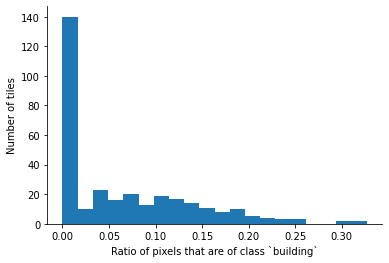

Mean Percentage of Pixels Belonging to Buildings: 0.064


In [ ]:
tile_type = '512_512 stride' # other options: '512_512 stride augmented', '256_256 stride', '512_512 stride augmented test', '512_512 stride augmented train'
percentages = check_dataset_balance(tile_type, augmented = False)

The dataset is highly imbalanced: on average, only 6.4 % of the pixels in a tile belong to the building class.

### 3.2. Manually labelled dataset consisting only of tiles containing buildings (259) (undersampling background class)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


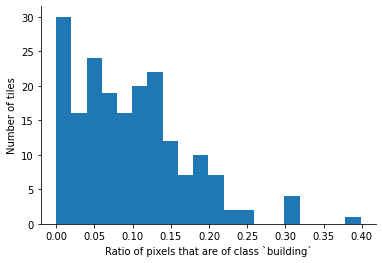

Mean Percentage of Pixels Belonging to Buildings: 0.098


In [ ]:
# Set size of images to use
tile_type = '512_512 undersampled' # other options: '512_512 stride augmented', '256_256 stride', '512_512 stride augmented test', '512_512 stride augmented train'
percentages = check_dataset_balance(tile_type, augmented = False)

While still being quite imbalanced, now almost 10% of the pixels in a tile belong to the building class.

## 4. Model Training

### 4.1. U-Net

#### 4.1.1. Use full manually labelled dataset (400 tiles) to find combination of loss function and backbone with highest dice score for later tests and comparisons between U-Net and HRNet

In [ ]:
tile_type = '512_512 stride'
fit_type = 'FOC full manually labelled (400 tiles)'
epochs = 200

To test different loss functions and backbones, models are trained for up to 200 epochs and evaluated using the dice-coefficient as it accounts for a high class imbalance.

##### 4.1.1.1. ResNet 18, ResNet 34, ResNet 50, VGG16, and ResNet 101 with Dice Loss

DiceLoss resnet18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,10.567662,10.298788,0.010336,00:37
1,9.216269,6.938994,0.615000,00:14
2,7.516970,5.687210,0.789921,00:14
3,6.480046,5.581895,0.801881,00:14
4,5.945739,5.234350,0.839953,00:14
5,5.648602,5.181092,0.845303,00:14
6,5.392334,5.050817,0.858502,00:14
7,5.135550,4.957103,0.871341,00:14
8,5.038618,5.016043,0.864587,00:14
9,4.929477,4.902050,0.874334,00:14


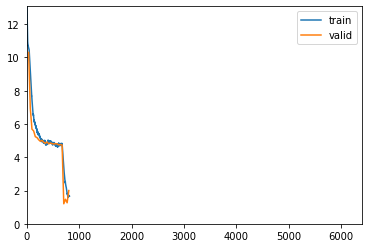

No improvement since epoch 23: early stopping
DiceLoss resnet34


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,11.686627,11.017922,0.004827,00:21
1,11.491988,11.017504,0.004859,00:15
2,11.414909,10.984359,0.009446,00:15
3,11.373474,10.815873,0.067195,00:15
4,11.871948,10.965318,0.011741,00:15
5,11.632411,10.935282,0.017785,00:15
6,11.488135,10.888022,0.028423,00:15
7,11.395687,10.766133,0.040181,00:15
8,10.056776,7.734456,0.592673,00:15
9,8.434311,5.524899,0.831049,00:15


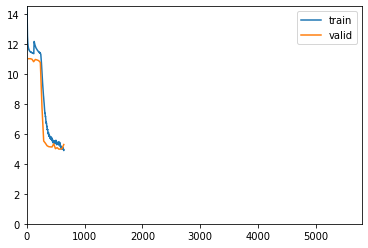

No improvement since epoch 19: early stopping
DiceLoss resnet50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,nan,nan,0.015237,01:21
1,nan,nan,0.033114,01:11
2,nan,nan,0.023672,01:11
3,nan,nan,0.015971,01:11
4,nan,nan,0.028726,01:11
5,nan,nan,0.051081,01:11
6,nan,nan,0.021383,01:11
7,nan,nan,0.026407,01:11
8,nan,nan,0.021435,01:11
9,nan,nan,0.050915,01:11


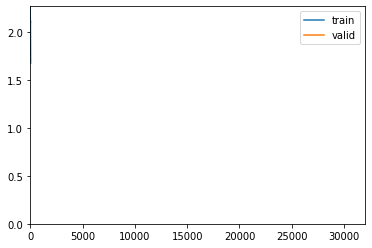

No improvement since epoch 15: early stopping
DiceLoss vgg16_bn


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,1.962960,1.294782,0.000000,01:22
1,1.322647,1.294627,0.000000,01:17
2,1.334055,1.294627,0.000000,01:17
3,1.343456,1.294627,0.000000,01:17
4,1.320540,1.294627,0.000000,01:17
5,1.254084,1.294627,0.000000,01:17
6,1.221135,1.294627,0.000000,01:17
7,1.352540,1.294627,0.000000,01:17
8,1.298576,1.294627,0.000000,01:17
9,1.391984,1.294627,0.000000,01:17


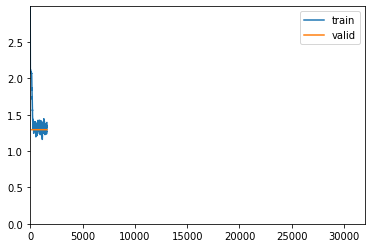

No improvement since epoch 0: early stopping


In [ ]:
loss_function = 'DiceLoss'
backbones = ['resnet18', 'resnet34', 'resnet50', 'vgg16_bn']
for backbone in backbones:
  print(loss_function, backbone)
  u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

epoch,train_loss,valid_loss,dice,time
0,nan,nan,0.054391,01:27
1,nan,nan,0.000000,01:16
2,nan,nan,0.000000,01:16
3,nan,nan,0.000000,01:16
4,nan,nan,0.000000,01:16
5,nan,nan,0.000000,01:16
6,nan,nan,0.000000,01:16
7,nan,nan,0.000000,01:16
8,nan,nan,0.000000,01:16
9,nan,nan,0.000000,01:17


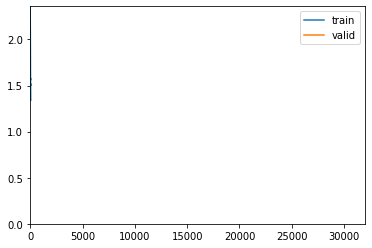

No improvement since epoch 0: early stopping


In [ ]:
loss_function = 'DiceLoss'
backbone = 'resnet101'
u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

Using dice loss, the ResNet34 model trained for 19 epochs has the highest dice-coefficient of 90.6 percent, closely followed by the ResNet18 model trained for 23 epochs: 89.9%.

##### 4.1.1.2. ResNet 18, ResNet 34, ResNet 50, VGG16, and ResNet 101 with Focal Loss

FocalLoss resnet18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

epoch,train_loss,valid_loss,dice,time
0,0.065600,0.039636,0.330136,00:19
1,0.046145,0.027039,0.657118,00:14
2,0.034876,0.020087,0.761195,00:14
3,0.028757,0.018403,0.787751,00:14
4,0.023701,0.014939,0.817242,00:14
5,0.020226,0.013434,0.847136,00:14
6,0.017388,0.013030,0.857436,00:14
7,0.015552,0.014589,0.845083,00:14
8,0.014755,0.013319,0.849881,00:14
9,0.014445,0.011557,0.856062,00:14


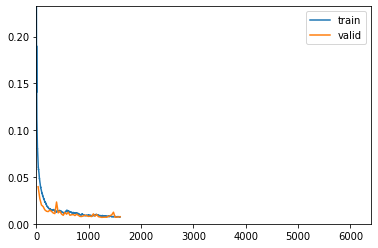

No improvement since epoch 40: early stopping
FocalLoss resnet34


epoch,train_loss,valid_loss,dice,time
0,0.067011,0.042509,0.478483,00:22
1,0.046530,0.025359,0.564763,00:15
2,0.034947,0.021434,0.751576,00:15
3,0.028970,0.018375,0.796783,00:15
4,0.023568,0.014537,0.832537,00:15
5,0.019880,0.013711,0.828853,00:15
6,0.018002,0.012906,0.861993,00:15
7,0.016764,0.014661,0.842613,00:15
8,0.015878,0.012330,0.863589,00:15
9,0.014629,0.010749,0.878040,00:15


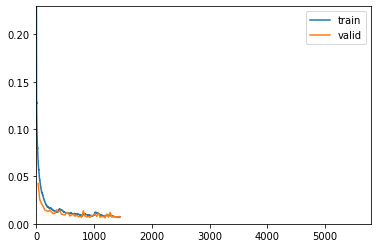

No improvement since epoch 40: early stopping
FocalLoss resnet50


epoch,train_loss,valid_loss,dice,time
0,0.034205,0.024292,0.540336,01:25
1,0.021273,0.024264,0.778405,01:17
2,0.020578,0.015567,0.783419,01:17
3,0.016889,0.013906,0.799575,01:17
4,0.014983,0.016971,0.826669,01:17
5,0.014619,0.011931,0.811997,01:17
6,0.014427,0.010720,0.875823,01:17
7,0.012521,0.008378,0.905307,01:17
8,0.011472,0.007780,0.912016,01:16
9,0.017610,0.011204,0.872134,01:17


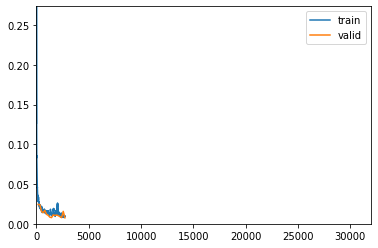

epoch,train_loss,valid_loss,dice,time
0,0.034205,0.024292,0.540336,01:25
1,0.021273,0.024264,0.778405,01:17
2,0.020578,0.015567,0.783419,01:17
3,0.016889,0.013906,0.799575,01:17
4,0.014983,0.016971,0.826669,01:17
5,0.014619,0.011931,0.811997,01:17
6,0.014427,0.010720,0.875823,01:17
7,0.012521,0.008378,0.905307,01:17
8,0.011472,0.007780,0.912016,01:16
9,0.017610,0.011204,0.872134,01:17


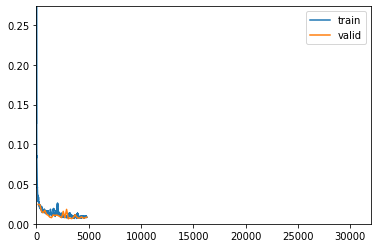

No improvement since epoch 20: early stopping
FocalLoss vgg16_bn


epoch,train_loss,valid_loss,dice,time
0,0.038378,0.028583,0.693848,01:23
1,0.029707,0.024733,0.731713,01:18
2,0.024589,0.025400,0.731227,01:18
3,0.021947,0.023529,0.723267,01:18
4,0.022955,0.024660,0.770772,01:18
5,0.019117,0.024042,0.779174,01:18
6,0.021250,0.022362,0.786363,01:18
7,0.017238,0.017904,0.815255,01:17
8,0.019733,0.016766,0.824676,01:17
9,0.017890,0.020943,0.772071,01:17


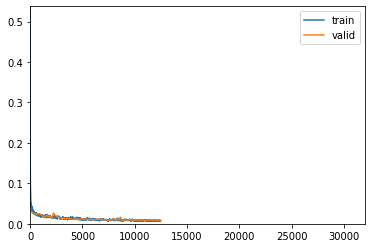

No improvement since epoch 68: early stopping


In [ ]:
loss_function = 'FocalLoss'
backbones = ['resnet18', 'resnet34', 'resnet50', 'vgg16_bn']
for backbone in backbones:
  print(loss_function, backbone)
  u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

epoch,train_loss,valid_loss,dice,time
0,0.026923,0.019850,0.808066,01:33
1,0.018008,0.024299,0.817749,01:25
2,0.018585,0.013136,0.862530,01:25
3,0.013856,0.013996,0.876620,01:25
4,0.013973,0.043836,0.862516,01:25
5,0.015612,0.062618,0.820027,01:24
6,0.012123,0.029451,0.869802,01:24
7,0.012731,0.038065,0.862141,01:24
8,0.012937,0.011667,0.872329,01:24
9,0.013250,0.014270,0.894418,01:24


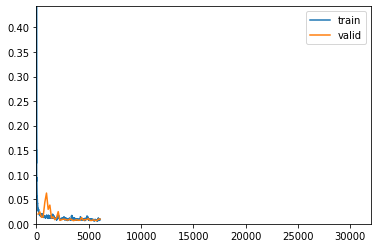

epoch,train_loss,valid_loss,dice,time
0,0.026923,0.019850,0.808066,01:33
1,0.018008,0.024299,0.817749,01:25
2,0.018585,0.013136,0.862530,01:25
3,0.013856,0.013996,0.876620,01:25
4,0.013973,0.043836,0.862516,01:25
5,0.015612,0.062618,0.820027,01:24
6,0.012123,0.029451,0.869802,01:24
7,0.012731,0.038065,0.862141,01:24
8,0.012937,0.011667,0.872329,01:24
9,0.013250,0.014270,0.894418,01:24


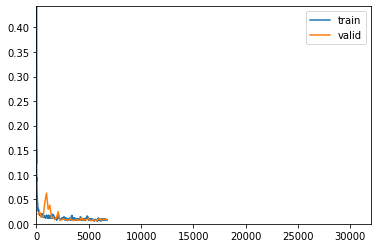

No improvement since epoch 32: early stopping


In [ ]:
loss_function = 'FocalLoss'
backbone = 'resnet101'
u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

Using focal loss, the ResNet 101 model trained for 32 epochs has the highest dice-coefficient of 93.5 percent, followed by the ResNet 34 model trained for 40 epochs: 93.1%.

##### 4.1.1.3. ResNet 18, ResNet 34, ResNet 50, VGG16, and ResNet 101 with Dual Focal Loss

Dual_Focal_loss resnet18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

epoch,train_loss,valid_loss,dice,time
0,0.196154,0.115859,0.370829,00:22
1,0.130226,0.077699,0.735309,00:16
2,0.093028,0.053361,0.794964,00:16
3,0.077780,0.055090,0.813177,00:16
4,0.068385,0.050445,0.827726,00:16
5,0.060357,0.042722,0.824847,00:16
6,0.056266,0.038362,0.856824,00:16
7,0.050212,0.035822,0.858271,00:16
8,0.048013,0.034128,0.876416,00:16
9,0.043437,0.034991,0.876985,00:16


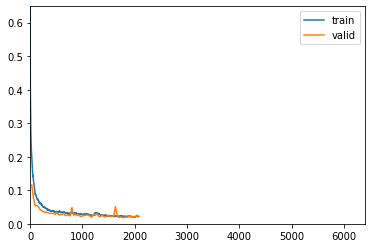

No improvement since epoch 55: early stopping
Dual_Focal_loss resnet34


epoch,train_loss,valid_loss,dice,time
0,0.200958,0.115175,0.323498,00:23
1,0.135401,0.092574,0.677640,00:16
2,0.104421,0.059083,0.719327,00:16
3,0.084281,0.049860,0.830036,00:16
4,0.069769,0.041162,0.850867,00:16
5,0.058500,0.045890,0.851906,00:16
6,0.056075,0.037297,0.866276,00:16
7,0.056147,0.038107,0.866757,00:16
8,0.050899,0.033244,0.877115,00:16
9,0.046304,0.038321,0.868058,00:16


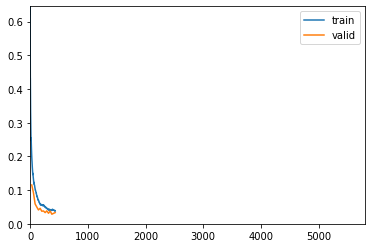

epoch,train_loss,valid_loss,dice,time
0,0.200958,0.115175,0.323498,00:23
1,0.135401,0.092574,0.677640,00:16
2,0.104421,0.059083,0.719327,00:16
3,0.084281,0.049860,0.830036,00:16
4,0.069769,0.041162,0.850867,00:16
5,0.058500,0.045890,0.851906,00:16
6,0.056075,0.037297,0.866276,00:16
7,0.056147,0.038107,0.866757,00:16
8,0.050899,0.033244,0.877115,00:16
9,0.046304,0.038321,0.868058,00:16


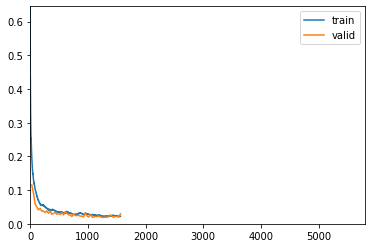

No improvement since epoch 44: early stopping
Dual_Focal_loss resnet50


epoch,train_loss,valid_loss,dice,time
0,0.089369,0.057166,0.763095,01:27
1,0.066383,0.040021,0.862127,01:19
2,0.056870,0.041384,0.859226,01:19
3,0.056562,0.033392,0.884978,01:19
4,0.040596,0.033136,0.880317,01:19
5,0.046555,0.031533,0.892270,01:19
6,0.038926,0.026628,0.905305,01:19
7,0.035127,0.026625,0.909496,01:19
8,0.041340,0.022875,0.916630,01:19
9,0.033115,0.024125,0.917829,01:19


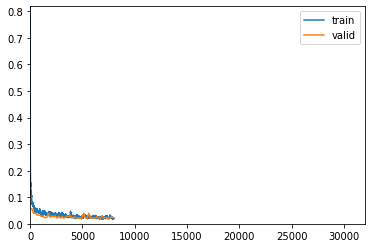

No improvement since epoch 40: early stopping
Dual_Focal_loss vgg16_bn


epoch,train_loss,valid_loss,dice,time
0,0.123704,0.087398,0.657974,01:25
1,0.079260,0.073876,0.739453,01:20
2,0.077852,0.067752,0.725484,01:20
3,0.067529,0.076206,0.755399,01:20
4,0.083031,0.064955,0.771780,01:20
5,0.068554,0.060157,0.789811,01:19
6,0.063187,0.051504,0.819099,01:19
7,0.061379,0.056082,0.789219,01:19
8,0.053956,0.061510,0.800687,01:19
9,0.057636,0.061823,0.769813,01:19


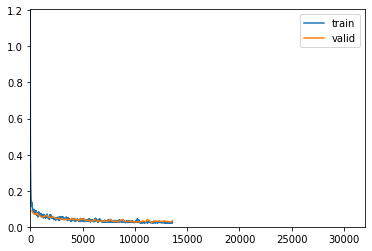

No improvement since epoch 75: early stopping
CombinedLoss resnet18


epoch,train_loss,valid_loss,dice,time


RuntimeError: ignored

In [ ]:
loss_function = 'Dual_Focal_loss'
backbones = ['resnet18', 'resnet34', 'resnet50', 'vgg16_bn']
for backbone in backbones:
  print(loss_function, backbone)
  u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

Loss Function:  Dual_Focal_loss


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

epoch,train_loss,valid_loss,dice,time
0,0.083486,0.059433,0.805691,01:34
1,0.056253,0.048160,0.843203,01:26
2,0.056511,0.049866,0.847606,01:26
3,0.044282,0.049983,0.839004,01:27
4,0.044775,0.036052,0.873650,01:27
5,0.037784,0.030193,0.897642,01:27
6,0.049989,0.029580,0.900081,01:26
7,0.036258,0.027955,0.907085,01:27
8,0.031655,0.029258,0.904941,01:26
9,0.032143,0.029540,0.899069,01:26


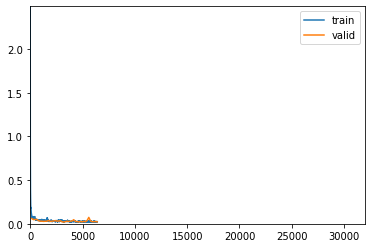

No improvement since epoch 30: early stopping
Loss Function:  CombinedLoss


epoch,train_loss,valid_loss,dice,time


RuntimeError: ignored

In [ ]:
loss_function = 'Dual_Focal_loss'
backbone = 'resnet101'
print('Loss Function: ', loss_function)
u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

Using dual focal loss, the ResNet34 model trained for 44 epochs has the highest dice-coefficient of 93.7 percent.

##### 4.1.1.4. ResNet 18, ResNet 34, ResNet 50, VGG16, and ResNet 101 with Combined Loss (Dice and Focal)

CombinedLoss resnet18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

epoch,train_loss,valid_loss,dice,time
0,9.288077,7.223857,0.601159,00:20
1,7.503873,5.666773,0.779347,00:15
2,5.312453,2.392707,0.798717,00:15
3,3.974793,2.183534,0.812985,00:15
4,3.492468,3.003490,0.716866,00:15
5,2.873650,1.941049,0.829617,00:15
6,2.526695,1.821539,0.833947,00:15
7,2.182357,1.756158,0.840159,00:15
8,1.930371,1.649708,0.857804,00:15
9,1.990868,2.537705,0.770829,00:15


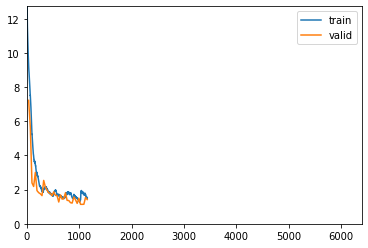

No improvement since epoch 26: early stopping
CombinedLoss resnet34


epoch,train_loss,valid_loss,dice,time
0,10.948333,8.567347,0.563139,00:22
1,8.685242,6.104644,0.792225,00:16
2,6.825640,2.766250,0.787656,00:16
3,4.948420,2.258461,0.826242,00:15
4,3.904995,2.267800,0.811161,00:15
5,3.233603,1.974728,0.845730,00:16
6,2.664660,2.052859,0.835637,00:16
7,2.392764,2.066924,0.838340,00:16
8,2.286399,1.796463,0.854828,00:16
9,2.193797,2.632391,0.790736,00:15


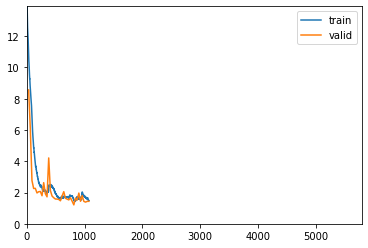

No improvement since epoch 27: early stopping
CombinedLoss resnet50


epoch,train_loss,valid_loss,dice,time
0,1.128513,0.675158,0.827058,01:26
1,0.747161,0.412013,0.861690,01:17
2,0.693928,0.588803,0.846290,01:17
3,0.598682,0.437694,0.870620,01:17
4,0.471855,0.364661,0.877284,01:17
5,0.535596,0.494198,0.826087,01:18
6,0.549095,0.372926,0.852357,01:17
7,0.546058,0.357790,0.882550,01:17
8,0.575546,0.581745,0.802767,01:17
9,0.473115,0.428685,0.838324,01:17


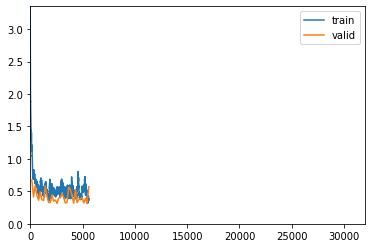

No improvement since epoch 25: early stopping
CombinedLoss vgg16_bn


epoch,train_loss,valid_loss,dice,time
0,1.463887,1.464700,0.686098,01:24
1,1.142450,0.871246,0.719500,01:18
2,1.038248,0.810688,0.745669,01:18
3,0.935668,0.771019,0.746209,01:18
4,0.867544,0.820286,0.700082,01:18
5,0.845066,0.666589,0.769160,01:17
6,0.815804,0.696630,0.734387,01:17
7,0.864788,0.650169,0.760184,01:17
8,0.871013,0.857773,0.699627,01:17
9,0.781340,0.629316,0.793644,01:17


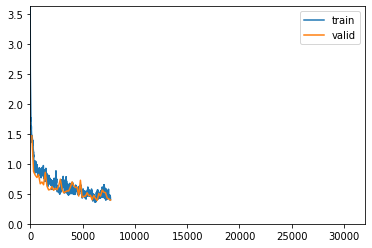

No improvement since epoch 38: early stopping


In [ ]:
loss_function = 'CombinedLoss'
backbones = ['resnet18', 'resnet34', 'resnet50', 'vgg16_bn']
for backbone in backbones:
  print(loss_function, backbone)
  u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

epoch,train_loss,valid_loss,dice,time
0,1.151931,0.661512,0.754853,01:32
1,0.827867,0.502970,0.811037,01:23
2,0.561483,0.530799,0.821220,01:23
3,0.594711,0.500858,0.810735,01:23
4,0.593427,0.522405,0.827115,01:23
5,0.561990,0.392892,0.872356,01:23
6,0.513361,0.420416,0.876283,01:23
7,0.491976,0.702127,0.816101,01:23
8,0.479743,0.384470,0.886998,01:23
9,0.418142,0.508283,0.870177,01:23


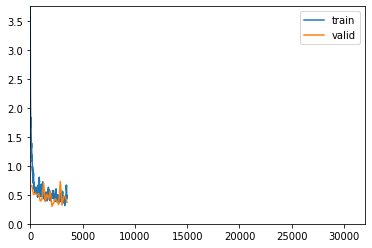

No improvement since epoch 12: early stopping


In [ ]:
loss_function = 'CombinedLoss'
backbone = 'resnet101'
u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

Using combined loss (focal and dice), the ResNet34 model trained for 27 epochs has the highest dice-coefficient of 91.2 percent.

On the original, un-augmented dataset, the best performing model was a ResNet34 trained for 44 epochs, using a dual focal loss function.

#### 4.1.2. Testing Performance on Different Dataset Sizes

Create new folders copying only 52, 102, 151, and 201 of the manually labelled tiles.

In [ ]:
tile_type = '512_512 undersampled'
tile_size = get_tile_size(tile_type)
fnames, lbl_names, path = check_fnames_lbls(tile_type, augmented = False)
img_train, img_test, msk_train, msk_test = train_test_split(fnames, lbl_names, test_size = i, random_state = 42)

splits = [.25, .49, .73, .97]
train_images = []

for i in splits:
  img_train, img_test, msk_train, msk_test = train_test_split(fnames, lbl_names, test_size = i, random_state = 42)
  number_training_images = round(len(fnames) * i - .2 * len(fnames) * i, 0)
  train_images.append(number_training_images)
  dir_img_tests = f'{path}/image_tiles/2019_10cm_RGB_BE_67/512_512 {number_training_images} training images'
  dir_msk_tests = f'{path}/buildings_mask_tiles/2019_10cm_RGB_BE_67/512_512 {number_training_images} training images'
  create_missing_folder(dir_img_tests)
  create_missing_folder(dir_msk_tests)
  
  # Copy files
  for file in img_test:
    shutil.copyfile(file, f"{dir_img_tests}/{str(file).split('/')[-1]}")
  for file in msk_test:
    shutil.copyfile(file, f"{dir_msk_tests}/{str(file).split('/')[-1]}")
    
print(train_images)

[52.0, 102.0, 151.0, 201.0]

Number of training images used : 52.0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

loss_function:  Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,0.350625,0.284649,0.394604,01:03
1,0.295446,0.207570,0.579385,00:33
2,0.251278,0.166589,0.619318,00:33
3,0.218437,0.113309,0.708668,00:33
4,0.189576,0.087438,0.755415,00:33
5,0.168166,0.075160,0.811323,00:33
6,0.152795,0.071929,0.841368,00:33
7,0.143477,0.073480,0.841790,00:33
8,0.134879,0.069482,0.852124,00:33
9,0.127255,0.064127,0.867857,00:33


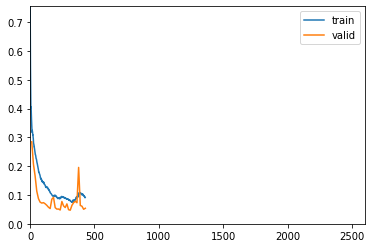

No improvement since epoch 23: early stopping
Number of training images used : 102.0
loss_function:  Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,0.526264,0.212856,0.273058,01:06
1,0.326200,0.160132,0.740367,01:03
2,0.248689,0.099550,0.775627,01:02
3,0.197823,0.094574,0.742551,01:02
4,0.161079,0.073161,0.849357,01:02
5,0.130246,0.077843,0.842172,01:02
6,0.118921,0.060191,0.877521,01:02
7,0.102650,0.055987,0.885634,01:03
8,0.092994,0.059724,0.877919,01:02
9,0.088135,0.062207,0.863603,01:02


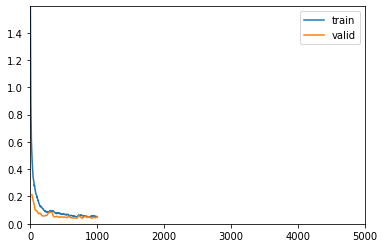

No improvement since epoch 30: early stopping
Number of training images used : 151.0
loss_function:  Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,0.164408,0.137313,0.647860,01:44
1,0.151721,0.132876,0.718551,01:34
2,0.120311,0.105864,0.823935,01:33
3,0.098561,0.093322,0.842915,01:33
4,0.088283,0.075903,0.866324,01:33
5,0.080883,0.075658,0.859025,01:32
6,0.068811,0.078355,0.869661,01:33
7,0.066833,0.069793,0.878544,01:32
8,0.070584,0.080086,0.860745,01:32
9,0.066133,0.061624,0.889797,01:32


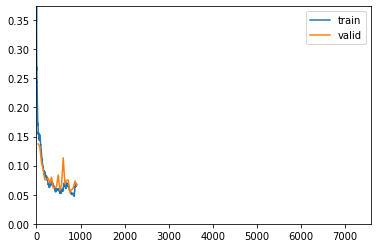

In [ ]:
# Retrieve values for train_images for model training
train_images = [52.0, 102.0, 151.0, 201.0]

backbone = 'resnet18'
loss_function = 'Dual_Focal_loss'

epochs = 200

for number in train_images:
  tile_type = f'512_512 {number} training images'
  print('Number of training images used :', number)
  fit_type = f'FOC {number} training images used'
  u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

Training stopped during the third experiment due to GPU usage issues, so the last two experiments were performed below.

Number of training images used : 151.0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

loss_function:  Dual_Focal_loss


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,0.187344,0.169221,0.678163,01:02
1,0.142806,0.117126,0.709976,00:18
2,0.111138,0.093506,0.833859,00:18
3,0.093206,0.095414,0.797539,00:18
4,0.079514,0.077157,0.861878,00:19
5,0.075801,0.084850,0.824990,00:18
6,0.078938,0.077889,0.866617,00:19
7,0.071789,0.069611,0.875963,00:19
8,0.063957,0.064275,0.885361,00:19
9,0.068623,0.107315,0.829986,00:19


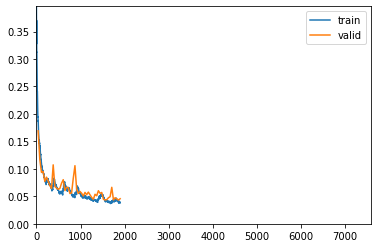

No improvement since epoch 40: early stopping
Number of training images used : 201.0
loss_function:  Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,0.344368,0.183565,0.503777,01:08
1,0.197003,0.111668,0.698595,00:24
2,0.137358,0.092836,0.803875,00:25
3,0.104443,0.078153,0.836703,00:25
4,0.086592,0.068416,0.857297,00:25
5,0.076680,0.062884,0.865588,00:25
6,0.069264,0.055963,0.877498,00:25
7,0.063672,0.055066,0.882359,00:25
8,0.060070,0.054999,0.880328,00:25
9,0.055855,0.060457,0.879167,00:25


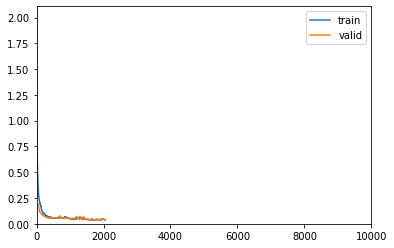

No improvement since epoch 31: early stopping


In [ ]:
# Retrieve values for train_images for model training
train_images = [151.0, 201.0]

backbone = 'resnet18'
loss_function = 'Dual_Focal_loss'

epochs = 200

for number in train_images:
  tile_type = f'512_512 {number} training images'
  print('Number of training images used :', number)
  fit_type = f'FOC {number} training images used'
  u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

The performance difference when increasing the number of manually labelled tiles from 52 to 207 is small. Initially, the model reaches an accuracy of 89.7% after 23 epochs. Roughly doubling the number of manually labelled tiles, the accuracy reaches 92.5% after 30 epochs. Using 155 manually labelled tiles, the model reaches 92.8 accuracy, but it only has to be trained for 40 epochs. Lastly, using 207 manually labelled tiles, the model again reaches an accuracy of 92.9%, training for 59 epochs.

Number of training images used : 52.0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


loss_function:  Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,0.353558,0.273297,0.111139,00:04
1,0.316078,0.263269,0.473673,00:04
2,0.282730,0.249591,0.138003,00:04
3,0.260540,0.185572,0.580269,00:04
4,0.242072,0.142708,0.586733,00:04
5,0.221006,0.119134,0.689790,00:04
6,0.203070,0.117028,0.717851,00:04
7,0.196657,0.194189,0.650126,00:04
8,0.190064,0.111826,0.599094,00:04
9,0.178340,0.102341,0.740833,00:04


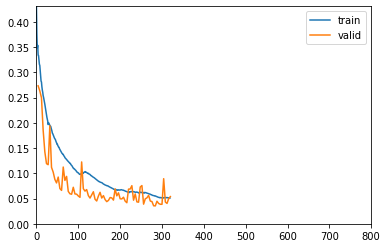

No improvement since epoch 70: early stopping
Number of training images used : 102.0
loss_function:  Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,0.650847,0.303106,0.002222,00:07
1,0.447680,0.213852,0.028277,00:07
2,0.358505,0.153136,0.566828,00:07
3,0.297502,0.126107,0.721845,00:07
4,0.256549,0.111332,0.776035,00:07
5,0.231370,0.108526,0.597226,00:07
6,0.209613,0.094577,0.785491,00:07
7,0.190304,0.083266,0.821464,00:07
8,0.174087,0.071999,0.824363,00:07
9,0.160454,0.075976,0.839778,00:07


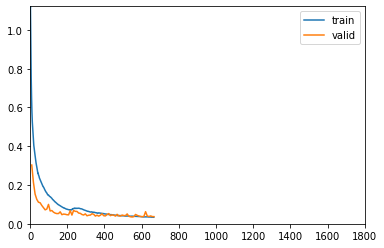

No improvement since epoch 64: early stopping
Number of training images used : 151.0
loss_function:  Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,0.228847,0.207095,0.423841,00:09
1,0.173560,0.128774,0.740242,00:09
2,0.143259,0.138759,0.759976,00:09
3,0.131288,0.115453,0.802581,00:09
4,0.119242,0.096533,0.808640,00:09
5,0.106822,0.095550,0.838445,00:09
6,0.097891,0.082901,0.842284,00:09
7,0.090273,0.075915,0.864857,00:09
8,0.085098,0.072807,0.872324,00:09
9,0.079659,0.078838,0.870525,00:09


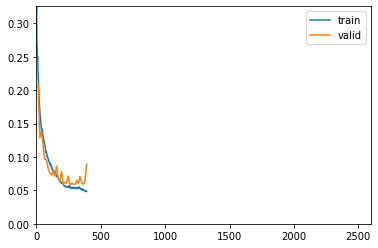

No improvement since epoch 20: early stopping
Number of training images used : 201.0
loss_function:  Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,0.372310,0.246914,0.089196,00:11
1,0.257052,0.148382,0.636889,00:11
2,0.199117,0.109399,0.720147,00:11
3,0.160835,0.103066,0.790128,00:11
4,0.133126,0.101404,0.800583,00:11
5,0.117706,0.075873,0.826953,00:11
6,0.103460,0.082652,0.836465,00:11
7,0.094498,0.079688,0.801883,00:11
8,0.088168,0.095471,0.822222,00:11
9,0.081327,0.065082,0.855187,00:11


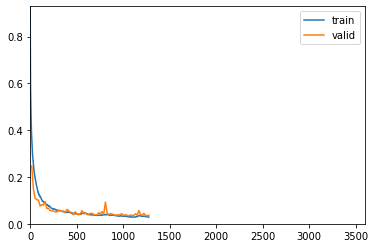

No improvement since epoch 61: early stopping


In [ ]:
# Retrieve values for train_images for model training
train_images = [52.0, 102.0, 151.0, 201.0]

backbone = 'resnet34'
loss_function = 'Dual_Focal_loss'
epochs = 200

for number in train_images:
  tile_type = f'512_512 {number} training images'
  print('Number of training images used :', number)
  fit_type = f'FOC {number} training images used'
  u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

The performance difference when increasing the number of manually labelled tiles from 52 to 207 is small. Initially, the model reaches an accuracy of 92% after 77 epochs. Roughly doubling the number of manually labelled tiles, the accuracy increases by 0.9% after 70 epochs. Using 155 manually labelled tiles, the model reaches a 0.1% lower accuracy, but it only has to be trained for 46 epochs. Lastly, using 207 manually labelled tiles, the model again reaches an accuracy of 92.9%, training for 59 epochs.

#### 4.1.3. Training on augmented tiles (1449 and 1725)

FOC augmented: 8, test split: 0.05


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,0.118399,0.099650,0.806095,01:33
1,0.079987,0.073908,0.854926,00:58
2,0.067833,0.064847,0.883409,00:58
3,0.062923,0.060753,0.883725,00:58
4,0.061041,0.058360,0.885903,00:58
5,0.052564,0.051537,0.901554,00:58
6,0.054288,0.050295,0.903364,00:58
7,0.049833,0.044302,0.917180,00:58
8,0.048973,0.050327,0.899356,00:58
9,0.051584,0.044345,0.917828,00:58


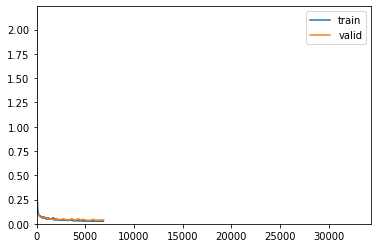

No improvement since epoch 30: early stopping
FOC augmented: 8, test split: 0.2


epoch,train_loss,valid_loss,dice,time
0,0.104872,0.072716,0.850219,01:17
1,0.077985,0.067513,0.846459,00:49


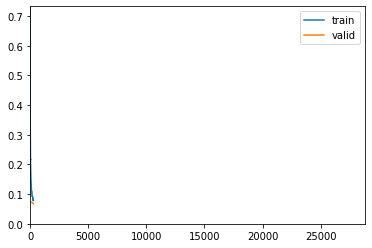

epoch,train_loss,valid_loss,dice,time
0,0.104872,0.072716,0.850219,01:17
1,0.077985,0.067513,0.846459,00:49
2,0.073741,0.056308,0.884215,00:50
3,0.064838,0.051028,0.887774,00:50
4,0.058742,0.054563,0.897721,00:50
5,0.060726,0.060530,0.889407,00:50
6,0.053774,0.050419,0.889572,00:50
7,0.053861,0.044449,0.904049,00:50
8,0.050488,0.043464,0.914219,00:50
9,0.049861,0.042106,0.913495,00:50


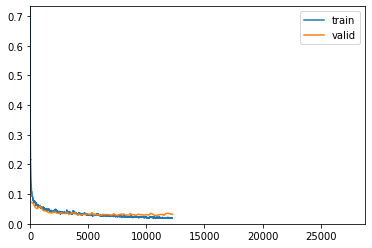

No improvement since epoch 75: early stopping


In [ ]:
tile_type = '512_512 augmented'
backbone = 'resnet18'
loss_function = 'Dual_Focal_loss'
epochs = 200

# Augmentation settings
augmentation_factor = 8
test_splits = [0.05, 0.2]

for split in test_splits:
  test_split = split
  fit_type = f'FOC augmented: {augmentation_factor}, test split: {test_split}'
  print(fit_type)
  u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = True, split = .2)

Using image augmentations and a validation split of 5 percent, ResNet18 reaches an accuracy of 93.8 percent after 30 epochs at a training time of 58 seconds/epoch. Using a validation split of 20 percent, the accuracy reaches 94.6 percent after 75 epochs and training takes 51 seconds/epoch.

FOC augmented augm: 8, test split: 0.05


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,0.103569,0.105865,0.786922,01:35
1,0.073806,0.075121,0.856389,01:02
2,0.065234,0.063127,0.883076,01:02
3,0.056420,0.063284,0.872351,01:02
4,0.058118,0.058990,0.897446,01:02
5,0.052345,0.050170,0.906444,01:02
6,0.057017,0.063502,0.869235,01:02
7,0.049806,0.051041,0.910974,01:02
8,0.046005,0.047491,0.918029,01:02
9,0.042204,0.049502,0.903344,01:02


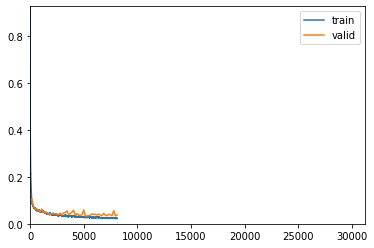

No improvement since epoch 42: early stopping
1735
FOC augmented augm: 8, test split: 0.2


epoch,train_loss,valid_loss,dice,time
0,0.102606,0.095842,0.816588,01:22
1,0.075650,0.059337,0.870651,00:52
2,0.065230,0.054826,0.887495,00:52
3,0.062675,0.050755,0.893304,00:52
4,0.058541,0.046938,0.901376,00:52
5,0.053258,0.043896,0.910265,00:52
6,0.054184,0.043619,0.909225,00:52
7,0.050364,0.041292,0.916382,00:52
8,0.047018,0.053993,0.894416,00:52
9,0.051565,0.039843,0.921058,00:52


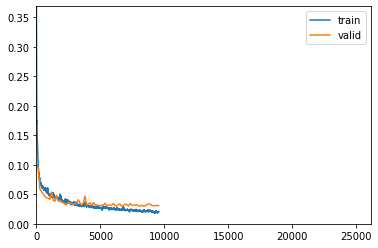

No improvement since epoch 63: early stopping
1501


In [ ]:
tile_type = '512_512 augmented'
backbone = 'resnet34'
loss_function = 'Dual_Focal_loss'
epochs = 200

# Augmentation settings
augmentation_factor = 8
test_splits = [0.05, 0.2]

for split in test_splits:
  test_split = split
  fit_type = f'FOC augmented: {augmentation_factor}, test split: {test_split}'
  print(fit_type)
  u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = True, split = .2)
  print(len(fnames))

Using image augmentations and a validation split of 5 percent, ResNet34 reaches an accuracy of 94.4% after 42 epochs at a training time of 1:02 minutes/epoch. Using a validation split of 20 percent, the accuracy reaches 94.5% after 63 epochs and training takes 53 seconds/epoch.

As these experiments showed, the best performing U-Net model when augmenting training images is the ResNet 18, which reaches 94.6% after 75 epochs.

### 4.2. HRNET

#### 4.2.1. Find combination of loss function and backbone with highest dice score on full manually labelled dataset (400 tiles)

Backbone: hrnet_w18, Loss Function: None


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


100%|██████████| 83749/83749 [00:04<00:00, 17264.51KB/s]


epoch,train_loss,valid_loss,dice,time
0,0.441054,0.591810,0.513562,00:32
1,0.318042,0.591280,0.437185,00:25
2,0.220660,0.636831,0.365580,00:25
3,0.157526,0.448587,0.738797,00:25
4,0.115409,0.279885,0.856939,00:25
5,0.088094,0.175368,0.879816,00:25
6,0.068396,0.098075,0.914889,00:24
7,0.054296,0.056690,0.919272,00:24
8,0.043497,0.043390,0.918404,00:25
9,0.035146,0.031145,0.926932,00:24


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


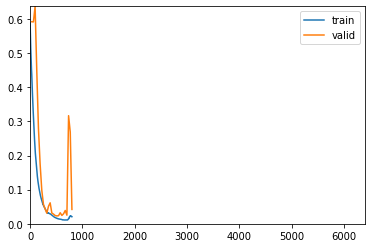

No improvement since epoch 15: early stopping
Backbone: hrnet_w18, Loss Function: DiceLoss


epoch,train_loss,valid_loss,dice,time
0,10.229194,11.523674,0.332321,00:21
1,8.895862,11.928068,0.175086,00:22
2,7.802389,11.640023,0.180494,00:21
3,6.994088,10.669878,0.265243,00:21
4,6.322728,8.916732,0.847872,00:21
5,5.788409,7.490018,0.874077,00:21
6,5.369873,6.320165,0.910197,00:21
7,5.026913,5.512900,0.885404,00:21
8,4.775136,5.157782,0.920754,00:22
9,4.532461,4.690034,0.922946,00:22


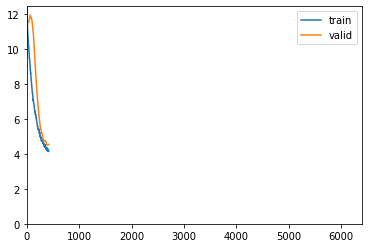

epoch,train_loss,valid_loss,dice,time
0,10.229194,11.523674,0.332321,00:21
1,8.895862,11.928068,0.175086,00:22
2,7.802389,11.640023,0.180494,00:21
3,6.994088,10.669878,0.265243,00:21
4,6.322728,8.916732,0.847872,00:21
5,5.788409,7.490018,0.874077,00:21
6,5.369873,6.320165,0.910197,00:21
7,5.026913,5.512900,0.885404,00:21
8,4.775136,5.157782,0.920754,00:22
9,4.532461,4.690034,0.922946,00:22


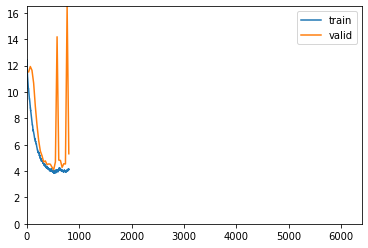

No improvement since epoch 15: early stopping
Backbone: hrnet_w18, Loss Function: FocalLoss


epoch,train_loss,valid_loss,dice,time
0,10.227735,11.504101,0.338779,00:21
1,8.894607,11.874794,0.179816,00:22
2,7.802735,11.568743,0.184008,00:22
3,6.997750,10.672743,0.251300,00:22
4,6.328269,9.114489,0.834195,00:22
5,5.797241,7.554862,0.874000,00:22
6,5.381090,6.086235,0.914143,00:21
7,5.034297,5.571332,0.890786,00:21
8,4.773568,5.159726,0.916128,00:21
9,4.532405,4.829513,0.922347,00:21


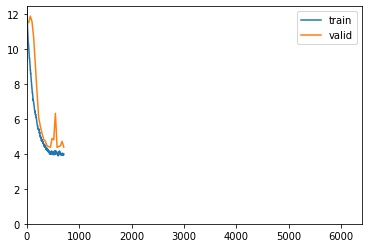

No improvement since epoch 12: early stopping
Backbone: hrnet_w18, Loss Function: Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,10.228326,11.511663,0.335659,00:22
1,8.895554,11.883961,0.179914,00:22
2,7.803156,11.608782,0.181871,00:21
3,6.997226,10.627672,0.266403,00:22
4,6.326870,8.958160,0.844536,00:22
5,5.793140,7.566429,0.874979,00:21
6,5.377749,6.164902,0.912574,00:21
7,5.031618,5.513933,0.893061,00:22
8,4.771029,5.295986,0.913702,00:21
9,4.534704,4.701807,0.924963,00:22


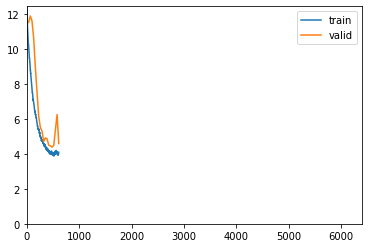

No improvement since epoch 9: early stopping
Backbone: hrnet_w18, Loss Function: CombinedLoss


epoch,train_loss,valid_loss,dice,time
0,10.368219,11.688546,0.344299,00:22
1,8.999512,12.015023,0.200370,00:22
2,7.865249,11.975939,0.177193,00:22
3,7.029274,10.754393,0.285135,00:22
4,6.347899,8.864742,0.847255,00:22
5,5.810523,7.658194,0.879813,00:21
6,5.388787,6.454333,0.906611,00:22
7,5.059179,5.766842,0.893491,00:22
8,4.811187,5.067682,0.917896,00:22
9,4.583407,5.050685,0.908225,00:22


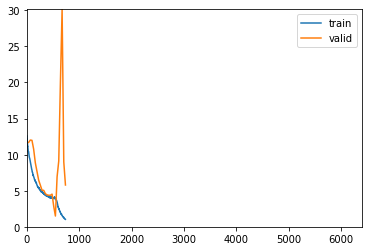

No improvement since epoch 13: early stopping


In [ ]:
tile_type = '512_512 stride'
backbone = 'hrnet_w18'
loss_functions = [None, 'DiceLoss', 'FocalLoss', 'Dual_Focal_loss', 'CombinedLoss']

for loss_function in loss_functions:
    print(f'Backbone: {backbone}, Loss Function: {loss_function}')
    fit_type = f'FOC full manually labelled (400 tiles), backbone: {backbone}, loss: {loss_function}'
    hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs = 200, augmented = False, split = .2)

The HRNet-W18 model achieved the following dice-coefficients:

*   93.3599% after 15 epochs using flattened cross entropy loss
*   93.3832% after 15 epochs using dice loss
*   92.7596	% after 12 epochs using focal loss
*   92.4963% after 9 epochs using dual focal loss
*   92.4025% after 13 epochs using a combination of dice and focal loss

Backbone: hrnet_w30, Loss Function: None


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


147942KB [00:07, 19406.75KB/s]                            


epoch,train_loss,valid_loss,dice,time
0,0.390820,0.902320,0.107275,00:35
1,0.227482,0.823431,0.110398,00:27
2,0.152701,0.653198,0.393873,00:27
3,0.110237,0.498850,0.763888,00:27
4,0.082360,0.340384,0.833695,00:27
5,0.065669,0.222468,0.879857,00:27
6,0.050853,0.145298,0.897994,00:27
7,0.040227,0.076964,0.920898,00:27
8,0.031972,0.061155,0.898514,00:28
9,0.025662,0.034751,0.928409,00:27


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


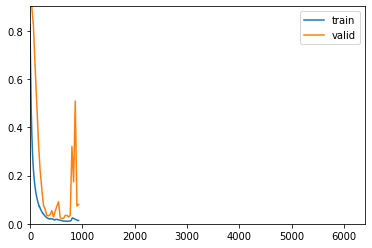

No improvement since epoch 19: early stopping
Backbone: hrnet_w30, Loss Function: DiceLoss


epoch,train_loss,valid_loss,dice,time
0,9.730740,14.508345,0.107274,00:24
1,7.883978,14.311915,0.110591,00:24
2,6.799366,12.179354,0.153033,00:25
3,6.069688,10.043449,0.739325,00:25
4,5.520490,7.993960,0.889222,00:24
5,5.107240,6.946984,0.865191,00:24
6,4.784292,5.449234,0.899293,00:24
7,4.519241,4.808799,0.913183,00:24
8,4.345438,4.451262,0.915262,00:25
9,4.198585,4.842004,0.840388,00:25


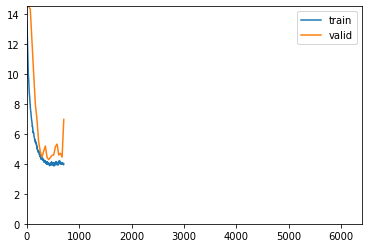

No improvement since epoch 12: early stopping
Backbone: hrnet_w30, Loss Function: FocalLoss


epoch,train_loss,valid_loss,dice,time
0,9.729958,14.516904,0.107272,00:24
1,7.883415,14.303632,0.110682,00:25
2,6.798800,12.168133,0.153538,00:25
3,6.069413,10.053638,0.737767,00:25
4,5.519003,8.080333,0.876123,00:24
5,5.092307,6.469217,0.897886,00:25
6,4.808603,5.101510,0.921764,00:25
7,4.530570,4.937056,0.912678,00:25
8,4.371797,4.502833,0.905434,00:25
9,4.231909,4.383584,0.921121,00:25


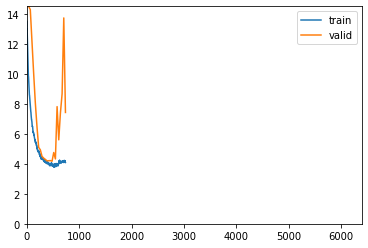

No improvement since epoch 13: early stopping
Backbone: hrnet_w30, Loss Function: Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,9.729328,14.524954,0.107269,00:24
1,7.882205,14.335139,0.110443,00:25
2,6.800405,12.175154,0.152773,00:24
3,6.072465,10.086280,0.728073,00:25
4,5.492617,8.323625,0.866749,00:25
5,5.113430,6.556533,0.890717,00:24
6,4.802207,4.954382,0.921436,00:24
7,4.533850,4.670301,0.906542,00:25
8,4.355282,4.405600,0.916619,00:25
9,4.200060,4.533890,0.902008,00:25


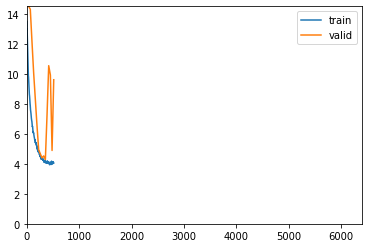

No improvement since epoch 6: early stopping
Backbone: hrnet_w30, Loss Function: CombinedLoss


epoch,train_loss,valid_loss,dice,time
0,9.906358,14.904379,0.107346,00:25
1,7.997782,14.781675,0.110459,00:25
2,6.969743,12.484174,0.151923,00:24
3,6.236106,10.141068,0.776245,00:25
4,5.641067,8.342733,0.834413,00:25
5,5.222915,6.668608,0.897357,00:25
6,4.870774,5.156212,0.920793,00:25
7,4.580921,4.801775,0.899929,00:25
8,4.396782,4.857052,0.891472,00:25
9,4.218245,4.658957,0.913336,00:25


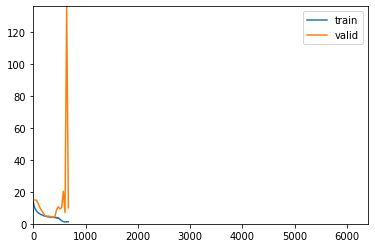

No improvement since epoch 11: early stopping


In [ ]:
tile_type = '512_512 stride'
backbone = 'hrnet_w30'
loss_functions = [None, 'DiceLoss', 'FocalLoss', 'Dual_Focal_loss', 'CombinedLoss']

for loss_function in loss_functions:
    print(f'Backbone: {backbone}, Loss Function: {loss_function}')
    fit_type = f'FOC full manually labelled (400 tiles), backbone: {backbone}, loss: {loss_function}'
    hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs = 200, augmented = False, split = .2)

The HRNet-W30 model (average time per epoch: 25 seconds) achieved the following dice-coefficients:

*   93.3569% after 19 epochs using flattened cross entropy loss
*   92.1997% after 12 epochs using dice loss
*   92.7484% after 13 epochs using focal loss
*   92.1436% after 6 epochs using dual focal loss
*   93.1976% after 11 epochs using a combination of dice and focal loss

Backbone: hrnet_w32, Loss Function: None


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


100%|██████████| 161707/161707 [00:08<00:00, 18071.46KB/s]


epoch,train_loss,valid_loss,dice,time
0,0.422356,0.778542,0.166551,00:35
1,0.243752,0.867483,0.252103,00:27
2,0.155301,0.644121,0.499796,00:27
3,0.107727,0.386433,0.750356,00:27
4,0.077856,0.230587,0.838952,00:27
5,0.059096,0.136898,0.882598,00:27
6,0.045438,0.075917,0.916512,00:27
7,0.036042,0.045887,0.925814,00:27
8,0.028722,0.039075,0.914723,00:28
9,0.023272,0.027113,0.930455,00:28


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


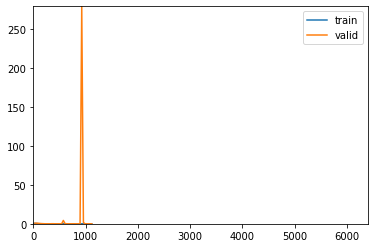

No improvement since epoch 25: early stopping
Backbone: hrnet_w32, Loss Function: DiceLoss


epoch,train_loss,valid_loss,dice,time
0,9.783983,12.979945,0.132071,00:24
1,7.975600,13.385424,0.140736,00:24
2,6.814436,11.411856,0.222303,00:25
3,6.030844,9.459134,0.738803,00:24
4,5.413005,7.394740,0.878520,00:25
5,4.965086,6.464586,0.904699,00:24
6,4.673371,5.522290,0.916781,00:24
7,4.430761,4.711845,0.928477,00:24
8,4.289261,4.417060,0.928311,00:24
9,4.141532,4.414356,0.916558,00:25


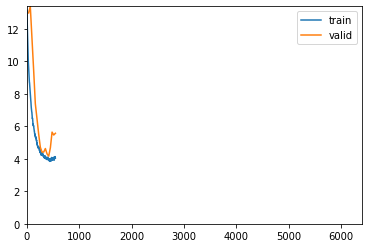

No improvement since epoch 7: early stopping
Backbone: hrnet_w32, Loss Function: FocalLoss


epoch,train_loss,valid_loss,dice,time
0,9.784079,12.981137,0.132154,00:25
1,7.975339,13.376493,0.140899,00:25
2,6.814196,11.397397,0.222728,00:25
3,6.030154,9.438716,0.740591,00:25
4,5.412697,7.388506,0.879685,00:25
5,4.963951,6.430251,0.905310,00:25
6,4.675486,5.539598,0.921486,00:24
7,4.425716,4.709563,0.925134,00:25
8,4.290445,4.546098,0.928245,00:25
9,4.144390,4.451695,0.923108,00:25


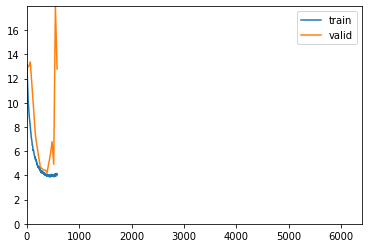

No improvement since epoch 8: early stopping
Backbone: hrnet_w32, Loss Function: Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,9.784848,12.982721,0.132082,00:24
1,7.976369,13.382190,0.140759,00:25
2,6.815549,11.408380,0.224057,00:25
3,6.031676,9.443056,0.739799,00:24
4,5.414526,7.368753,0.878443,00:25
5,4.967841,6.528676,0.904734,00:24
6,4.679722,5.458886,0.919737,00:24
7,4.434997,4.681504,0.926338,00:25
8,4.300314,4.364841,0.928789,00:25
9,4.148288,4.414195,0.911232,00:25


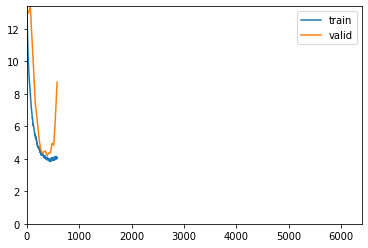

No improvement since epoch 8: early stopping
Backbone: hrnet_w32, Loss Function: CombinedLoss


epoch,train_loss,valid_loss,dice,time
0,9.969138,13.594104,0.126597,00:24
1,8.048820,14.695107,0.134322,00:24
2,6.850920,12.066713,0.202732,00:25
3,6.060701,9.526826,0.774455,00:25
4,5.435946,7.385709,0.870473,00:25
5,4.980960,6.247159,0.913764,00:25
6,4.679959,5.762568,0.923270,00:25
7,4.430538,4.648910,0.927834,00:25
8,4.292138,4.601089,0.929064,00:25
9,4.142859,4.430644,0.927366,00:25


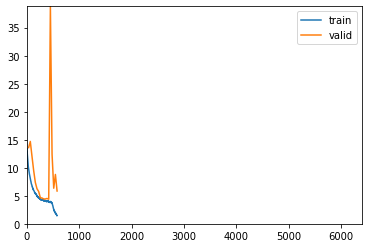

No improvement since epoch 8: early stopping


In [ ]:
tile_type = '512_512 stride'
backbone = 'hrnet_w32'
loss_functions = [None, 'DiceLoss', 'FocalLoss', 'Dual_Focal_loss', 'CombinedLoss']

for loss_function in loss_functions:
    print(f'Backbone: {backbone}, Loss Function: {loss_function}')
    fit_type = f'FOC full manually labelled (400 tiles), backbone: {backbone}, loss: {loss_function}'
    hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs = 200, augmented = False, split = .2)

The HRNet-W32 model (average time per epoch: 27 seconds) achieved the following dice-coefficients:

*   93.4300% after 25 epochs using flattened cross entropy loss
*   92.8477% after 7 epochs using dice loss
*   92.8245% after 8 epochs using focal loss
*   92.8789% after 8 epochs using dual focal loss
*   92.7834% after 7 epochs using a combination of dice and focal loss

Backbone: hrnet_w48, Loss Function: None


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice,time
0,0.655919,0.736808,0.110336,00:50
1,0.633410,0.705749,0.143117,00:30
2,0.608809,0.677123,0.232609,00:30
3,0.584024,0.650632,0.353838,00:30
4,0.553882,0.627515,0.447603,00:30
5,0.520964,0.605284,0.514194,00:30
6,0.482274,0.585076,0.560210,00:30
7,0.438535,0.562780,0.607753,00:30
8,0.391745,0.527113,0.661281,00:30
9,0.342781,0.478107,0.714526,00:30


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


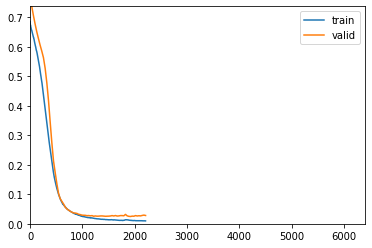

No improvement since epoch 59: early stopping
Backbone: hrnet_w48, Loss Function: DiceLoss


epoch,train_loss,valid_loss,dice,time


RuntimeError: ignored

In [ ]:
 tile_type = '512_512 stride'
backbone = 'hrnet_w48'
loss_functions = [None, 'DiceLoss']

for loss_function in loss_functions:
    print(f'Backbone: {backbone}, Loss Function: {loss_function}')
    fit_type = f'FOC full manually labelled (400 tiles), backbone: {backbone}, loss: {loss_function}'
    hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs = 200, augmented = False, split = .2)

Backbone: hrnet_w48, Loss Function: DiceLoss


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice,time
0,8.322517,13.768176,0.111146,00:27
1,6.611925,13.543292,0.132950,00:27
2,5.758686,11.308661,0.266223,00:27
3,5.205196,9.202690,0.861115,00:28
4,4.788311,7.689066,0.889016,00:28
5,4.476391,6.397046,0.922797,00:28
6,4.304065,6.255805,0.908801,00:28
7,4.171550,5.192943,0.884825,00:28
8,4.120617,4.466405,0.921805,00:28
9,4.017148,4.524914,0.921615,00:28


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


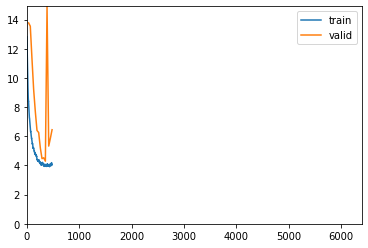

No improvement since epoch 5: early stopping
Backbone: hrnet_w48, Loss Function: FocalLoss


epoch,train_loss,valid_loss,dice,time
0,8.322861,13.760826,0.111259,00:28
1,6.610680,13.547918,0.134299,00:28
2,5.742807,11.322693,0.247204,00:28
3,5.196744,9.237486,0.835435,00:28
4,4.784856,7.832007,0.882852,00:28
5,4.468225,6.696946,0.923101,00:28
6,4.318013,7.123152,0.744157,00:28
7,4.188828,5.454488,0.910630,00:28
8,4.132491,4.691219,0.911874,00:28
9,4.052913,4.818088,0.879864,00:28


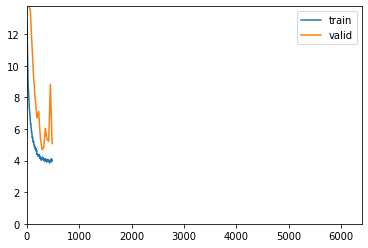

No improvement since epoch 5: early stopping
Backbone: hrnet_w48, Loss Function: Dual_Focal_loss


epoch,train_loss,valid_loss,dice,time
0,8.321762,13.761266,0.111203,00:28
1,6.608935,13.563385,0.133539,00:28
2,5.724857,11.315818,0.287982,00:28
3,5.200435,9.303818,0.848742,00:28
4,4.797038,7.818778,0.865465,00:28
5,4.482303,6.454236,0.913066,00:28
6,4.329494,5.677873,0.912980,00:28
7,4.183815,5.176745,0.893488,00:29
8,4.107937,4.530614,0.921081,00:28
9,4.000567,4.602934,0.903066,00:28


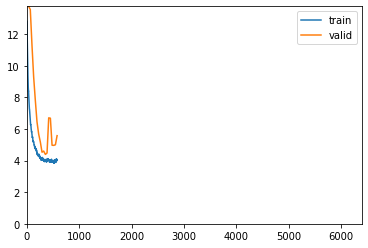

No improvement since epoch 8: early stopping
Backbone: hrnet_w48, Loss Function: CombinedLoss


epoch,train_loss,valid_loss,dice,time
0,8.504468,13.803411,0.113016,00:28
1,6.736976,13.507812,0.135149,00:28
2,5.846924,11.317225,0.368829,00:28
3,5.266588,9.285317,0.866752,00:28
4,4.828904,7.652292,0.897213,00:28
5,4.489658,6.586478,0.922496,00:28
6,4.292427,5.607574,0.930893,00:28
7,4.142859,4.664251,0.930902,00:28
8,4.057908,4.540331,0.927846,00:28
9,3.965878,5.169915,0.894165,00:28


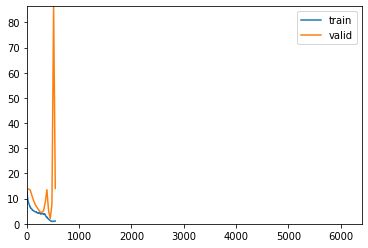

No improvement since epoch 7: early stopping


In [ ]:
tile_type = '512_512 stride'
backbone = 'hrnet_w48'
loss_functions = ['DiceLoss', 'FocalLoss', 'Dual_Focal_loss', 'CombinedLoss']

for loss_function in loss_functions:
    print(f'Backbone: {backbone}, Loss Function: {loss_function}')
    fit_type = f'FOC full manually labelled (400 tiles), backbone: {backbone}, loss: {loss_function}'
    hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs = 200, augmented = False, split = .2)

The HRNet-W48 model (average time per epoch: 28 seconds) achieved the following dice-coefficients:

*   93.0379% after 59 epochs using flattened cross entropy loss
*   92.2797% after 5 epochs using dice loss
*   92.3101% after 5 epochs using focal loss
*   92.1081% after 8 epochs using dual focal loss
*   93.0902% after 7 epochs using a combination of dice and focal loss

Having tested all implemented backbones and loss functions, the two HRNet models for further testing are:


* HRNet-W18 (flattened cross entropy loss): 93.36% after 15 epochs (total training time: 360 seconds)
* HRNet-W48 (combined dice and focal loss): 93.09% after 7 epochs (total training time: 196 seconds)




#### 4.2.2. Training on different dataset sizes

In [ ]:
# Retrieve values for train_images for model training
train_images = [52.0, 102.0, 151.0, 201.0]

Number of training images used : 52.0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice,time
0,0.584261,0.628990,0.527597,00:15
1,0.536695,0.654732,0.392062,00:05
2,0.496478,0.683455,0.318328,00:05
3,0.458759,0.711169,0.268205,00:05
4,0.423419,0.740158,0.246549,00:05
5,0.388798,0.787497,0.230685,00:05
6,0.356040,0.869946,0.211468,00:05
7,0.325471,0.990524,0.201082,00:05
8,0.296918,1.105525,0.197242,00:05
9,0.271338,1.263616,0.195434,00:05


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


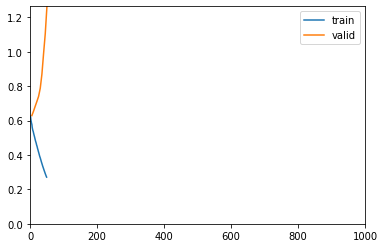

No improvement since epoch 0: early stopping
Number of training images used : 102.0


epoch,train_loss,valid_loss,dice,time
0,0.621647,0.827007,0.193881,00:17
1,0.544281,0.873994,0.193613,00:09
2,0.475372,0.948742,0.193664,00:09
3,0.413849,1.030442,0.193833,00:09
4,0.357768,1.068796,0.194202,00:09
5,0.310171,1.069334,0.200470,00:09
6,0.269103,1.079635,0.211403,00:09
7,0.234202,0.985856,0.226056,00:09
8,0.204341,0.872399,0.277158,00:09
9,0.179064,0.710378,0.404764,00:09


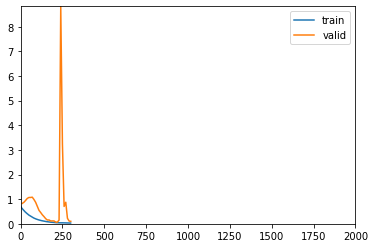

No improvement since epoch 20: early stopping
Number of training images used : 151.0


epoch,train_loss,valid_loss,dice,time
0,0.693187,0.974890,0.191593,00:18
1,0.570124,1.050903,0.191635,00:12
2,0.462716,1.239241,0.191689,00:12
3,0.376793,1.278768,0.192062,00:13
4,0.309426,1.188761,0.194635,00:12
5,0.257670,1.163550,0.202229,00:12
6,0.214091,0.754332,0.296428,00:12
7,0.179655,0.581176,0.531049,00:12
8,0.151801,0.363987,0.788098,00:12
9,0.128526,0.233475,0.869813,00:12


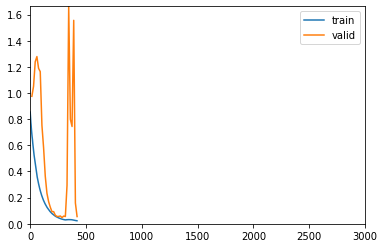

No improvement since epoch 18: early stopping
Number of training images used : 201.0


epoch,train_loss,valid_loss,dice,time
0,0.661525,0.749755,0.226127,00:16
1,0.515048,0.846194,0.229217,00:16
2,0.395868,0.976353,0.223809,00:16
3,0.307601,1.092837,0.217335,00:16
4,0.242252,0.955798,0.248263,00:16
5,0.193602,0.696600,0.442403,00:16
6,0.156750,0.471245,0.723295,00:16
7,0.128436,0.304161,0.855689,00:16
8,0.105963,0.206684,0.886430,00:16
9,0.088698,0.171234,0.879709,00:16


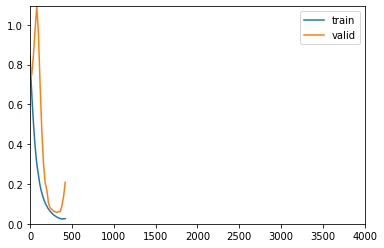

No improvement since epoch 11: early stopping


In [ ]:
# Test done on NVIDIA Tesla V100-SXM2 16 GB
backbone = 'hrnet_w18'
loss_function = None
epochs = 200

for number in train_images:
  tile_type = f'512_512 {number} training images'
  print('Number of training images used :', number)
  fit_type = f'FOC {number} training images used'
  hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs, augmented = False, split = .2, bs = 10)

The performance difference when increasing the number of manually labelled tiles from 52 to 207 is large. Initially, the model reaches an accuracy of 52.76%  after 1 epoch. Roughly doubling the number of manually labelled tiles, the accuracy increases to 92% after 20 epochs. Using 155 manually labelled tiles, the model reaches a 92.3% after 18 epochs. Lastly, using 207 manually labelled tiles, the model again reaches an accuracy of 92.3% after 11 epochs.

Number of training images used : 52.0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


100%|██████████| 303363/303363 [00:13<00:00, 22291.05KB/s]


epoch,train_loss,valid_loss,dice,time
0,12.771393,10.256363,0.194896,00:15
1,11.333547,10.270294,0.194854,00:06
2,10.046606,10.769266,0.194847,00:06
3,8.981339,11.315728,0.194844,00:06
4,8.100480,11.480632,0.194870,00:06
5,7.314580,11.558740,0.194958,00:06
6,6.699517,11.575036,0.194979,00:06
7,6.092700,11.644154,0.194961,00:06
8,5.548556,11.504074,0.195123,00:06
9,5.074900,11.315429,0.195445,00:06


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


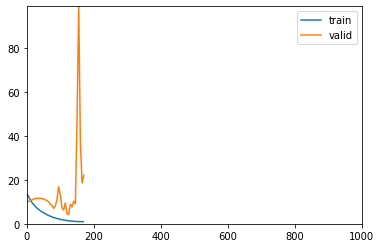

No improvement since epoch 24: early stopping
Number of training images used : 102.0


epoch,train_loss,valid_loss,dice,time
0,11.371911,10.868185,0.197891,00:17
1,9.288182,11.447762,0.194425,00:10
2,7.800434,11.452506,0.195840,00:10
3,6.727098,11.153538,0.202660,00:10
4,5.891325,10.684098,0.269657,00:10
5,5.174702,10.521959,0.292465,00:10
6,4.505450,10.112766,0.395732,00:10
7,3.928572,8.997010,0.591369,00:10
8,3.411131,8.206198,0.738920,00:10
9,2.968571,7.559915,0.741440,00:10


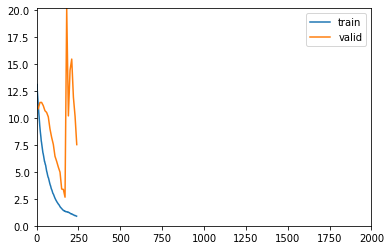

No improvement since epoch 14: early stopping
Number of training images used : 151.0


epoch,train_loss,valid_loss,dice,time
0,9.806273,12.196307,0.191601,00:22
1,7.540694,12.592008,0.191903,00:14
2,6.062837,12.371661,0.192796,00:14
3,5.004837,11.395172,0.251067,00:14
4,4.197591,10.340830,0.490548,00:14
5,3.554276,9.184935,0.654081,00:14
6,2.976549,8.040158,0.781094,00:14
7,2.503904,7.003219,0.886032,00:14
8,2.107812,6.299257,0.897073,00:15
9,1.769196,5.081467,0.909226,00:14


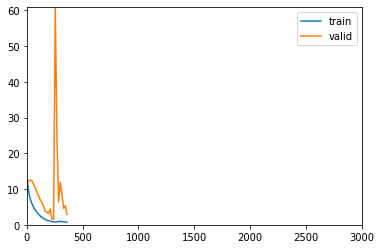

No improvement since epoch 14: early stopping
Number of training images used : 201.0


epoch,train_loss,valid_loss,dice,time
0,9.026149,12.609497,0.201127,00:24
1,6.677948,12.544112,0.203439,00:18
2,5.288350,11.227163,0.373270,00:18
3,4.303897,10.120861,0.595843,00:18
4,3.488410,8.869290,0.730758,00:18
5,2.823907,7.569619,0.817817,00:18
6,2.279619,6.508934,0.885661,00:18
7,1.855790,5.221349,0.903500,00:18
8,1.490476,3.931543,0.920948,00:18
9,1.231763,3.149836,0.918592,00:18


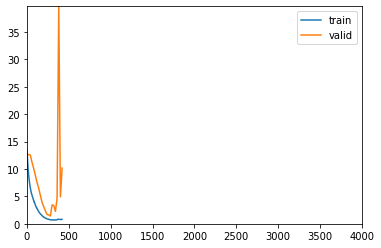

No improvement since epoch 11: early stopping


In [ ]:
# Test done on NVIDIA P100 16GB
backbone = 'hrnet_w48'
loss_function = 'CombinedLoss'
epochs = 200

for number in train_images:
  tile_type = f'512_512 {number} training images'
  print('Number of training images used :', number)
  fit_type = f'FOC {number} training images used'
  hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs, augmented = False, split = .2, bs = 10)

#### 4.2.3. Training on augmented tiles (1449 and 1725)

FOC augmented: 8, test split: 0.05


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


100%|██████████| 83749/83749 [00:03<00:00, 26493.24KB/s]


epoch,train_loss,valid_loss,dice,time
0,0.331471,0.765768,0.365328,12:27
1,0.186933,0.640697,0.482979,01:12
2,0.121001,0.269841,0.852740,01:12
3,0.087001,0.139327,0.884627,01:12
4,0.066407,0.090025,0.894316,01:12
5,0.052343,0.074732,0.898478,01:11
6,0.042661,0.072248,0.896584,01:12
7,0.035608,0.062409,0.909565,01:12
8,0.030572,0.057800,0.920825,01:12
9,0.027105,0.055961,0.923925,01:12


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


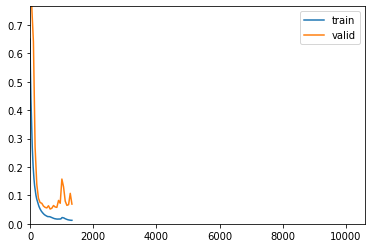

No improvement since epoch 15: early stopping
1735
FOC augmented: 8, test split: 0.2


epoch,train_loss,valid_loss,dice,time
0,0.365647,0.719439,0.358748,10:47
1,0.219308,0.729385,0.389213,01:01
2,0.144710,0.377075,0.818708,01:01
3,0.103394,0.190971,0.882195,01:01
4,0.078223,0.112536,0.894914,01:01
5,0.061283,0.077707,0.902123,01:01
6,0.049596,0.064798,0.905591,01:01
7,0.041054,0.053338,0.918539,01:01
8,0.034900,0.046111,0.929099,01:01
9,0.032074,0.055097,0.913159,01:01


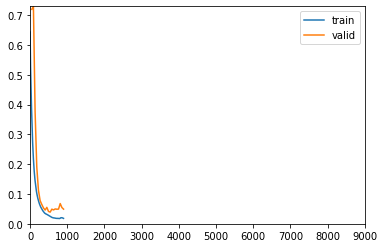

epoch,train_loss,valid_loss,dice,time
0,0.365647,0.719439,0.358748,10:47
1,0.219308,0.729385,0.389213,01:01
2,0.144710,0.377075,0.818708,01:01
3,0.103394,0.190971,0.882195,01:01
4,0.078223,0.112536,0.894914,01:01
5,0.061283,0.077707,0.902123,01:01
6,0.049596,0.064798,0.905591,01:01
7,0.041054,0.053338,0.918539,01:01
8,0.034900,0.046111,0.929099,01:01
9,0.032074,0.055097,0.913159,01:01


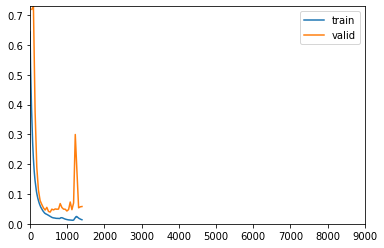

No improvement since epoch 21: early stopping
1501


In [ ]:
# TESLA V 100
tile_type = '512_512 augmented'
backbone = 'hrnet_w18'
loss_function = None
epochs = 200

# Augmentation settings
augmentation_factor = 8
test_splits = [0.05, 0.2]

for split in test_splits:
  test_split = split
  fit_type = f'FOC augmented: {augmentation_factor}, test split: {test_split}'
  print(fit_type)
  hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs, augmented = True, split = .2)
  print(len(fnames))

HRNet-W18:
*   93.2919% after 15 epochs of training using 5% validation split (1735 training tiles).
*   93.9877% after 21 epochs of training using 20% validation split (1501 training images)

FOC augmented: 8, test split: 0.05


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice,time
0,7.466265,12.650514,0.684741,01:43
1,3.583516,5.530906,0.909852,01:35
2,2.212259,1.752984,0.921698,01:35
3,1.626612,1.274668,0.919210,01:35
4,1.424340,1.025280,0.935575,01:35
5,1.243089,0.996136,0.933351,01:34
6,1.214629,1.209037,0.928219,01:35
7,1.266665,1.163160,0.924460,01:35
8,1.128108,0.899740,0.938858,01:35
9,1.068222,1.306739,0.911651,01:35


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


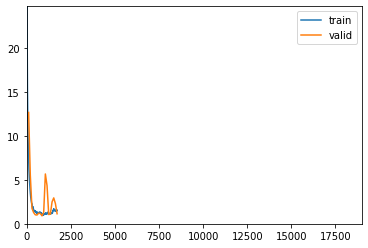

No improvement since epoch 8: early stopping
1735
FOC augmented: 8, test split: 0.2


epoch,train_loss,valid_loss,dice,time
0,8.710088,18.757656,0.371984,01:55
1,4.431168,10.992524,0.888260,01:20
2,2.695305,4.348258,0.926904,01:20
3,1.898787,2.278044,0.929208,01:20
4,1.497805,1.745701,0.931700,01:20
5,1.325791,1.391114,0.937796,01:20
6,1.270049,1.629864,0.934354,01:20
7,1.243099,1.708327,0.929788,01:20
8,1.305881,3.640081,0.847951,01:20
9,1.140774,1.759837,0.931318,01:19


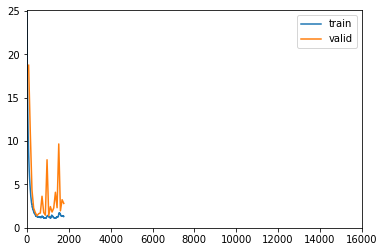

No improvement since epoch 12: early stopping
1501


In [ ]:
# TESLA V 100
tile_type = '512_512 augmented'
backbone = 'hrnet_w48'
loss_function = 'CombinedLoss'
epochs = 200

# Augmentation settings
augmentation_factor = 8
test_splits = [0.05, 0.2]

for split in test_splits:
  test_split = split
  fit_type = f'FOC augmented: {augmentation_factor}, test split: {test_split}'
  print(fit_type)
  hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs, augmented = True, split = .2)
  print(len(fnames))

HRNet-W48:
*   93.8858% after 8 epochs of training using 5% validation split (1735 training tiles).
*   93.8513% after 12 epochs of training using 20% validation split (1501 training images)

## 5. Inference Speed Tests

### 5.1. U-Net

#### 5.1.1. ResNet-18

In [ ]:
# Re-initiate learn object and load saved models to perform inference tests
tfms = [*aug_transforms(mult = 1.0, do_flip = True, flip_vert = True, max_rotate = 40.0,
                          min_zoom = 1.0, max_zoom = 1.4, max_warp = 0.4),
          Normalize.from_stats(*imagenet_stats)]
tile_type = "512_512 stride"
mask_type = "buildings"
mask_subfolder = "2019_10cm_RGB_BE_67"
path = Path(f"/content/drive/MyDrive/Segmentation Data/aerial")
codes = ['Background', 'Building']
bs = 8 # also tried 16 and 32 (more not possible due to GPU RAM limit)

# Get all image and label tiles and check if their number is equal
fnames = get_image_files(f'{path}/image_tiles/{mask_subfolder}/{tile_type}')
lbl_names = get_image_files(f'{path}/{mask_type}_mask_tiles/{mask_subfolder}/{tile_type}')
p2c = n_codes(lbl_names)

# Create function to load images and masks
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y, bs = bs, codes = codes, seed = 2, batch_tfms = tfms)
  
# Initiate model
learn = unet_learner(dls, resnet18, n_out = 2, metrics = [Dice()]).to_fp16()

# Load previously trained and saved Resnet18 model
learner_name = 'U-Net_resnet18_Dual_Focal_loss_8x augmented heavy tfms_2022-03-02_18:08_saved_model'
learn.load(f'/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/saved/{learner_name}')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 with a batch size of 8
duration = test_inference(dls, learn)
duration

datetime.timedelta(seconds=89, microseconds=77591)

In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 with a batch size of 16
duration = test_inference(dls, learn)
duration

datetime.timedelta(seconds=76, microseconds=749743)

In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 with a batch size of 32
duration = test_inference(dls, learn)
duration

datetime.timedelta(seconds=157, microseconds=49740)

The fastest inference of the ResNet18 model using an NVIDIA Tesla V100-SXM2 was achieved using a batch size of 16: 76 seconds.

#### 5.1.2. ResNet-34

Since there were no previously saved models, another ResNet34 was trained for inference.

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


loss_function:  Dual_Focal_loss


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,0.184358,0.090072,0.515156,00:33
1,0.119249,0.066526,0.672678,00:22
2,0.093382,0.051800,0.811870,00:22
3,0.076190,0.046424,0.809521,00:22
4,0.066302,0.063508,0.800939,00:22
5,0.060233,0.041154,0.857976,00:22
6,0.052874,0.035540,0.869997,00:22
7,0.048475,0.043917,0.855837,00:22
8,0.046365,0.033809,0.878647,00:23
9,0.041995,0.036284,0.879908,00:22


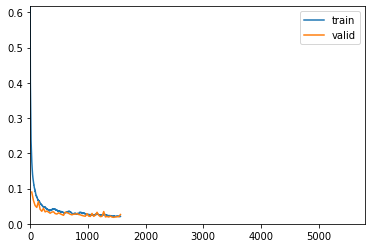

No improvement since epoch 44: early stopping


In [ ]:
# Train model to use for inference
tile_type = '512_512 stride'
backbone = 'resnet34'
loss_function = 'Dual_Focal_loss'
fit_type = 'FOC full manually labelled (400 tiles)'
epochs = 200
learn, dls = u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = False, split = .2)

In [ ]:
# Saving trained ResNet-34 model
architecture = 'U-Net'
model_save_path = f"{model_dir}/saved/{architecture}_{backbone}_{loss_function}_{fit_type}_{timestamp()}"
learn.save(f"{model_save_path}_saved_model", with_opt = True)

Path('/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/saved/U-Net_resnet34_Dual_Focal_loss_FOC full manually labelled (400 tiles)_2022-03-14_16:51_saved_model.pth')

In [ ]:
tfms = [*aug_transforms(mult = 1.0, do_flip = True, flip_vert = True, max_rotate = 40.0,
                          min_zoom = 1.0, max_zoom = 1.4, max_warp = 0.4),
          Normalize.from_stats(*imagenet_stats)]
tile_type = "512_512 stride"
mask_type = "buildings"
mask_subfolder = "2019_10cm_RGB_BE_67"
path = Path(f"/content/drive/MyDrive/Segmentation Data/aerial")
codes = ['Background', 'Building']
bs = 8 # also tried 11 and 16 (more not possible due to GPU RAM limit)

# Get all image and label tiles and check if their number is equal
fnames = get_image_files(f'{path}/image_tiles/{mask_subfolder}/{tile_type}')
lbl_names = get_image_files(f'{path}/{mask_type}_mask_tiles/{mask_subfolder}/{tile_type}')
p2c = n_codes(lbl_names)

# Create function to load images and masks
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func = get_y, bs = bs, codes = codes, seed = 2, batch_tfms = tfms)
  
# Create model
learn = unet_learner(dls, resnet34, n_out = 2, metrics = [Dice()]).to_fp16()

# Re-load trained and saved ResNet34 model and test inference speed on NVIDIA Tesla V100-SXM2
learner_name = 'U-Net_resnet34_Dual_Focal_loss_FOC full manually labelled (400 tiles)_2022-03-14_16:51_saved_model'
learn.load(f'/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/saved/{learner_name}')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 with a batch size of 8
duration = test_inference(dls, learn)
duration

datetime.timedelta(seconds=89, microseconds=487304)

In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 with a batch size of 11
duration = test_inference(dls, learn)
duration

datetime.timedelta(seconds=91, microseconds=445512)

In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 with a batch size of 16
duration = test_inference(dls, learn)
duration

datetime.timedelta(seconds=80, microseconds=768282)

The fastest inference of the ResNet-34 model using an NVIDIA Tesla V100-SXM2 was achieved using a batch size of 16: 80 seconds.

### 5.2. HRNet

#### 5.2.1. W18 Backbone

FOC augmented: 8, test split: 0.2 final model to save


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


100%|██████████| 83749/83749 [00:02<00:00, 41311.81KB/s]


epoch,train_loss,valid_loss,dice,time
0,0.365623,0.722933,0.355524,01:37
1,0.219280,0.730299,0.389702,00:55
2,0.144678,0.376100,0.818680,00:55
3,0.103358,0.190638,0.882147,00:55
4,0.078205,0.111855,0.895504,00:55
5,0.061258,0.077439,0.902136,00:55
6,0.049562,0.064430,0.905603,00:55
7,0.041020,0.052856,0.920300,00:55
8,0.035013,0.047921,0.926461,00:55
9,0.031918,0.053775,0.915493,00:55


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


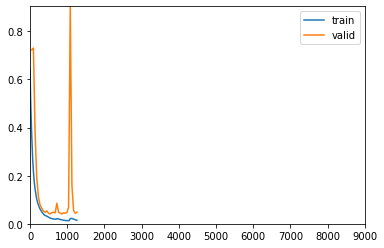

No improvement since epoch 18: early stopping


In [ ]:
# Train and save final hrnet_w18 model on NVIDIA A100-SXM4-40GB
tile_type = '512_512 augmented'
backbone = 'hrnet_w18'
loss_function = None
epochs = 200

# Augmentation settings
test_split = .2
fit_type = f'FOC augmented: 8, test split: {test_split} final model to save'
print(fit_type)
learn, dls = hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs, augmented = True, split = .2)

In [ ]:
# Saving trained HRNet-W18 model
architecture = 'HRNet'
loss_function = 'Flattened cross entropy loss'
model_save_path = f"{model_dir}/saved/{architecture}_{backbone}_{loss_function}_{fit_type}_{timestamp()}"
learn.save(f"{model_save_path}_saved_model", with_opt = True)

Path('/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/saved/HRNet_hrnet_w18_Flattened cross entropy loss_FOC augmented: 8, test split: 0.2 final model to save_2022-03-14_10:22_saved_model.pth')

In [ ]:
# Load and export best HRNet model to use for later inference
learn = learn.load(f'{model_dir}/saved/HRNet_hrnet_w18_Flattened cross entropy loss_FOC augmented: 8, test split: 0.2 final model to save_2022-03-14_14:53_saved_model')
learn.export(f'{model_dir}/exported/HRNet_hrnet_w18_Flattened cross entropy loss_FOC augmented: 8, test split: 0.2 final model to save_2022-03-14_14:53_exported')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
# Reload best HRNet model
learn = load_learner(f'{model_dir}/exported/HRNet_hrnet_w18_Flattened cross entropy loss_FOC augmented: 8, test split: 0.2 final model to save_2022-03-14_14:53_exported', cpu = False)

In [ ]:
# Initialise learner and adapt batch sizes
tile_type = '512_512 augmented'
backbone = 'hrnet_w18'
loss_function = None
test_split = .2
seed()
tile_size = get_tile_size(tile_type)
fnames, lbl_names, path = check_fnames_lbls(tile_type, augmented = True)
bs = 16 # also tried 32, 64 and 128
p2c = n_codes(lbl_names)
splitter = FuncSplitter(lambda fn: Path(fn).parent.name == 'valid')
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)), get_items = get_image_files,
            splitter = splitter, get_y = get_y_augmented)
dls = db.dataloaders(path/'img', bs = bs, valid_pct = .2)
if loss_function == None:
  loss = None
learn = get_segmentation_learner(dls, number_classes = 2, segmentation_type = "Semantic Segmentation",
                                   architecture_name = "hrnet", backbone_name = backbone,
                                   model_dir = model_dir, metrics = [Dice()], splitter = trainable_params,
                                   pretrained = True, loss_func = loss).to_fp16()

# Load trained and saved HRNet-W18 model for each experiment using a different batch size
learner_name = 'HRNet_hrnet_w18_Flattened cross entropy loss_FOC augmented: 8, test split: 0.2 final model to save_2022-03-14_10:22_saved_model'
learn.load(f'/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/saved/{learner_name}')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


100%|██████████| 83749/83749 [00:03<00:00, 21600.06KB/s]


In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 using a batch size of 16
duration = test_inference(dls, learn)
duration

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


datetime.timedelta(seconds=73, microseconds=198458)

In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 using a batch size of 32
duration = test_inference(dls, learn)
duration

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


datetime.timedelta(seconds=50, microseconds=275458)

In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 using a batch size of 64
duration = test_inference(dls, learn)
duration

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


datetime.timedelta(seconds=45, microseconds=102193)

In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 using a batch size of 128
duration = test_inference(dls, learn)
duration

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


datetime.timedelta(seconds=96, microseconds=385687)

The fastest inference of the HRNet-W18 model using an NVIDIA Tesla V100-SXM2 was achieved using a batch size of 64: 45 seconds.

#### 5.2.2. W48 Backbone

FOC augmented: 8, test split: 0.2 final model to save


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


100%|██████████| 303363/303363 [00:11<00:00, 27288.48KB/s]


epoch,train_loss,valid_loss,dice,time
0,8.714150,18.840248,0.357008,04:47
1,4.457573,11.207189,0.876991,01:25
2,2.698490,4.305037,0.922220,01:24
3,1.874538,2.612909,0.910608,01:24
4,1.500919,1.820693,0.931079,01:25
5,1.317001,1.519573,0.933575,01:25
6,1.304018,2.090142,0.922998,01:25
7,1.216931,1.279047,0.940412,01:25
8,1.219390,1.442797,0.938984,01:25
9,1.279278,4.854281,0.781195,01:24


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


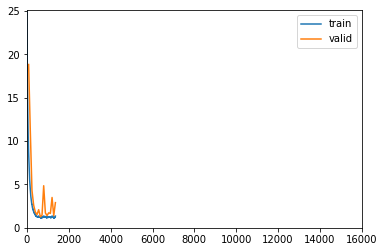

No improvement since epoch 7: early stopping


In [ ]:
# Trained on an NVIDIA TESLA V 100
tile_type = '512_512 augmented'
backbone = 'hrnet_w48'
loss_function = 'CombinedLoss'
epochs = 200

# Augmentation settings
test_split = .2
fit_type = f'FOC augmented: 8, test split: {test_split} final model to save'
print(fit_type)
learn, dls = hrnet_model_training(tile_type, backbone, loss_function, fit_type, epochs, augmented = True, split = .2)

In [ ]:
# Saving trained HRNet-W48 model
architecture = 'HRNet'
loss_function = 'CombinedLoss'
model_save_path = f"{model_dir}/saved/{architecture}_{backbone}_{loss_function}_{fit_type}_{timestamp()}"
learn.save(f"{model_save_path}_saved_model", with_opt = True)

Path('/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/saved/HRNet_hrnet_w48_CombinedLoss_FOC augmented: 8, test split: 0.2 final model to save_2022-03-14_12:04_saved_model.pth')

In [ ]:
# Initialise learner and adapt batch sizes
tile_type = '512_512 augmented'
backbone = 'hrnet_w48'
loss_function = 'CombinedLoss'
test_split = .2
seed()
tile_size = get_tile_size(tile_type)
fnames, lbl_names, path = check_fnames_lbls(tile_type, augmented = True)
bs = 32 # also tried 64 and 128 (more note possible due to GPU RAM limit)
p2c = n_codes(lbl_names)
splitter = FuncSplitter(lambda fn: Path(fn).parent.name == 'valid')
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)), get_items = get_image_files,
            splitter = splitter, get_y = get_y_augmented)
dls = db.dataloaders(path/'img', bs = bs, valid_pct = .2)
if loss_function == 'CombinedLoss':
  loss = CombinedLoss()
learn = get_segmentation_learner(dls, number_classes = 2, segmentation_type = "Semantic Segmentation",
                                   architecture_name = "hrnet", backbone_name = backbone,
                                   model_dir = model_dir, metrics = [Dice()], splitter = trainable_params,
                                   pretrained = True, loss_func = loss).to_fp16()

# Load trained and saved HRNet-W48 model for each experiment using a different batch size
learner_name = 'HRNet_hrnet_w48_CombinedLoss_FOC augmented: 8, test split: 0.2 final model to save_2022-03-14_12:04_saved_model'
learn.load(f'/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/saved/{learner_name}')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 using a batch size of 16
duration = test_inference(dls, learn)
duration

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


datetime.timedelta(seconds=75, microseconds=929143)

In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 using a batch size of 32
duration = test_inference(dls, learn)
duration

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


datetime.timedelta(seconds=62, microseconds=883427)

In [ ]:
# Test inference speed on NVIDIA Tesla V100-SXM2 using a batch size of 64
duration = test_inference(dls, learn)
duration

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


datetime.timedelta(seconds=61, microseconds=935237)

The fastest inference of the HRNet-W48 model using an NVIDIA Tesla V100-SXM2 was achieved using a batch size of 64: 61 seconds.

FOC augmented: 8, test split: 0.2


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
 

loss_function:  Dual_Focal_loss


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,dice,time
0,0.102479,0.073028,0.851078,01:20
1,0.073132,0.077324,0.858778,00:49
2,0.067231,0.053294,0.883171,00:50
3,0.063920,0.056666,0.889947,00:50
4,0.058528,0.046330,0.903540,00:49
5,0.055038,0.044346,0.910088,00:50
6,0.054258,0.050356,0.901782,00:50
7,0.051787,0.042533,0.907198,00:50
8,0.049324,0.040461,0.920336,00:50
9,0.046513,0.039999,0.921858,00:50


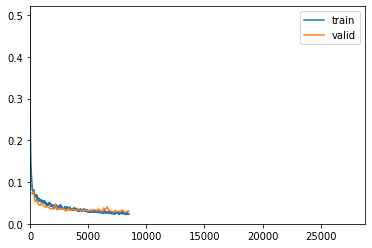

No improvement since epoch 49: early stopping


In [ ]:
# Train final model for inference results testing
tile_type = '512_512 augmented'
backbone = 'resnet18'
loss_function = 'Dual_Focal_loss'
epochs = 200

# Augmentation settings
augmentation_factor = 8
split = 0.2
test_split = split
fit_type = f'FOC augmented: {augmentation_factor}, test split: {test_split}'
print(fit_type)
learn, dls = u_net_model_training(tile_type, backbone, loss_function, fit_type, epochs, architecture = 'U-Net', augmented = True, split = .2)

In [ ]:
model_save_path = f"{model_dir}/saved/U-Net_{backbone}_{loss_function}_{fit_type}_{timestamp()}"
learn.export(f'{model_save_path}_exported.pkl')

## 6. Check number of model parameters

In [ ]:
learn_hrnet = load_learner('/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/exported/HRNet_hrnet_w18_Flattened cross entropy loss_FOC augmented: 8, test split: 0.2 final model to save_2022-03-14_14:53_exported')
learn_unet = load_learner('/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/exported/U-Net_resnet18_Dual_Focal_loss_8x augmented heavy tfms_2022-03-02_18:13_exported.pkl')

In [ ]:
total_params(learn_hrnet)

(9636512, True)

In [ ]:
total_params(learn_unet)

(31113008, False)